In [11]:
########################### Generate Random Compositions of HEAs #######################
import random
import pandas as pd

# Updated list of elements based on your input
METALLIC_ELEMENTS = ["Li", "Be", "B", "C", "N", "Mg", "Al", "Si", "Sc", "Ti", "V", 
                     "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Y", "Zr", "Nb", "Mo", 
                       "Pd", "Ag", "Sn", "Te", "Ba", 
                            "Hf", "Ta", "W", "Re", "Au"]

RARE_EARTH_ELEMENTS = ["La"]

# Define the counts for each type of composition based on given distribution and total sample count
TOTAL_COUNT = 5000
COMPOSITION_COUNTS = {
    2: int(0.1 * TOTAL_COUNT),
    3: int(0.1 * TOTAL_COUNT),
    4: int(0.2 * TOTAL_COUNT),
    5: int(0.3 * TOTAL_COUNT),
    6: int(0.2 * TOTAL_COUNT),
    7: int(0.05 * TOTAL_COUNT),
    8: int(0.05 * TOTAL_COUNT)
}

def generate_random_composition(num_elements):
    """
    Generate a random composition of 'num_elements' elements.
    """
    if random.random() < 0.1 and num_elements > 1:  # 10% chance to include a rare earth element
        composition = random.sample(RARE_EARTH_ELEMENTS, 1)
        num_elements -= 1
    else:
        composition = []

    composition += random.sample([e for e in METALLIC_ELEMENTS if e not in composition], num_elements)
    
    return composition

def generate_variant(composition):
    """
    Generate molar fraction variants for a given composition.
    """
    fractions = [round(random.uniform(0.5, 1.5), 2) for _ in composition]
    return " ".join(f"{element}{fraction}" for element, fraction in zip(composition, fractions))

all_compositions = []

# Generate the required number of compositions
for num_elements, count in COMPOSITION_COUNTS.items():
    for _ in range(count):
        composition = generate_random_composition(num_elements)
        variant1 = generate_variant(composition)
        variant2 = generate_variant(composition)
        all_compositions.append(variant1)
        all_compositions.append(variant2)

# Save to CSV
df = pd.DataFrame(all_compositions, columns=['composition'])
df.to_csv('new_compositions.csv', index=False)

print(f"{len(df)} compositions saved to 'compositions.csv'")


10000 compositions saved to 'compositions.csv'


In [ ]:
###########################To Spaces format for BERT #######################
import pandas as pd
import re

def transform_composition(comp):
    # Check if the composition is a string, if not return it as is
    if not isinstance(comp, str):
        return comp
    
    # Split composition based on capital letters (denoting element symbols)
    elements = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', comp)
    
    # Format each element-symbol and number pair
    new_elements = [f"{elem[0]}{elem[1] if elem[1] else 1}" for elem in elements]
    
    # Join the formatted pairs with spaces
    return " ".join(new_elements)

# Load the CSV
input_filepath = 'Fernado_1.csv'
df = pd.read_csv(input_filepath)

# Ensure the 'composition' column exists in the dataframe
if 'composition' in df.columns:
    # Transform the 'composition' column
    df['composition'] = df['composition'].apply(transform_composition)
else:
    print("'composition' column not found in the CSV.")

# Save the modified dataframe to a new CSV
output_filepath = 'Fernado_1.csv'
df.to_csv(output_filepath, index=False)



In [ ]:
################################Check for any Duplicates #############################
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Fernado_1.csv')

# Check for duplicate compositions
duplicate_compositions = df[df.duplicated(subset='composition', keep=False)]

if not duplicate_compositions.empty:
    print("Found duplicate compositions!")
    print(duplicate_compositions)
else:
    print("No duplicate compositions found.")
    

############################# Delete Dublicates and keep one instance ######################
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('Fernado_1.csv')

# Find duplicate compositions
duplicates = df[df.duplicated(subset='composition', keep=False)]

# For duplicated compositions, check if they have different phases
diff_phase_compositions = []

for composition in duplicates['composition'].unique():
    unique_phases = duplicates[duplicates['composition'] == composition]['hardness'].nunique()
    
    if unique_phases > 1:
        diff_phase_compositions.append(composition)

# Remove rows with compositions that have different phases
df = df[~df['composition'].isin(diff_phase_compositions)]

# Drop duplicates based on 'compositions' while keeping the first occurrence
df = df.drop_duplicates(subset='composition', keep='first')

# Save the cleaned dataframe back to a CSV
df.to_csv('Fernado_1.csv', index=False)


In [2]:
################################################Add features if have only compositions available with Spaces##########################

########################################################## VEC #######################################

import re

# Define the valence electron concentrations for each element
vec_values = {
    "Li": 1, "Be": 2, "B": 3, "C": 4, "N": 5, "O": 6, "Na": 1, "Mg": 2, "Al": 3, "Si": 4, "P": 5, "S": 6,
    "K": 1, "Ca": 2, "Sc": 3, "Ti": 4, "V": 5, "Cr": 6, "Mn": 7, "Fe": 8, "Co": 9, "Ni": 10, "Cu": 11, "Zn": 12,
    "Ga": 3, "Ge": 4, "Se": 6, "Rb": 1, "Sr": 2, "Y": 3, "Zr": 4, "Nb": 5, "Mo": 6, "Tc": 7, "Ru": 8, "Rh": 9,
    "Pd": 10, "Ag": 11, "Cd": 12, "In": 3, "Sn": 4, "Te": 6, "Cs": 1, "Ba": 2, "La": 3, "Ce": 4, "Pr": 5, "Nd": 6,
    "Pm": 7, "Sm": 8, "Eu": 9, "Gd": 10, "Tb": 11, "Dy": 12, "Ho": 3, "Er": 4, "Tm": 5, "Yb": 6, "Lu": 7, "Hf": 8,
    "Ta": 9, "W": 10, "Re": 11, "Os": 12, "Ir": 3, "Pt": 4, "Au": 5, "Tl": 6, "Pb": 7, "Po": 8, "Th": 9, "Pa": 10,
    "U": 11
}

def split_formula(formula):
    """
    Split the formula string into a list of tuples containing element symbols and their corresponding amounts.

    :param formula: A string representing the alloy formula
    :return: A list of tuples (element symbol, amount) in the alloy
    """
    components = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', formula)
    parsed_components = [(element, float(amount) if amount else 1) for element, amount in components]
    return parsed_components

def calculate_mean_vec(formula):
    """
    Calculate the mean valence electron concentration (VEC) for a given alloy formula.

    :param formula: A string representing the alloy formula
    :return: The mean VEC of the alloy
    """
    alloy = split_formula(formula)

    # Calculate the sum of VEC values for each element in the alloy, considering their amounts
    vec_sum = sum(vec_values[element] * amount for element, amount in alloy)

    # Calculate the mean VEC by dividing the total VEC sum by the sum of element amounts
    mean_vec = vec_sum / sum(amount for _, amount in alloy)

    return mean_vec

formula = "Co0.2Cr0.2Fe0.2Mn0.2Ni0.2"
mean_vec = calculate_mean_vec(formula)

print(f"The mean VEC of the alloy {formula} is: {mean_vec}")

#################################################### Electronegativity ###########################
import re

# Define the electronegativity values for each element
electronegativity_values = {
    "Li": 0.98, "Be": 1.57, "B": 2.04, "C": 2.55, "N": 3.04, "O": 3.44, "Na": 0.93, "Mg": 1.31,
    "Al": 1.61, "Si": 1.90, "P": 2.19, "S": 2.58, "K": 0.82, "Ca": 1.00, "Sc": 1.36, "Ti": 1.54,
    "V": 1.63, "Cr": 1.66, "Mn": 1.55, "Fe": 1.83, "Co": 1.88, "Ni": 1.91, "Cu": 1.90, "Zn": 1.65,
    "Ga": 1.81, "Ge": 2.01, "Se": 2.55, "Rb": 0.82, "Sr": 0.95, "Y": 1.22, "Zr": 1.33, "Nb": 1.6,
    "Mo": 2.16, "Tc": 1.9, "Ru": 2.2, "Rh": 2.28, "Pd": 2.20, "Ag": 1.93, "Cd": 1.69, "In": 1.78,
    "Sn": 1.96, "Te": 2.1, "Cs": 0.79, "Ba": 0.89, "La": 1.10, "Ce": 1.12, "Pr": 1.13, "Nd": 1.14,
    "Pm": 1.13, "Sm": 1.17, "Eu": 1.2, "Gd": 1.2, "Tb": 1.1, "Dy": 1.22, "Ho": 1.23, "Er": 1.24,
    "Tm": 1.25, "Yb": 1.1, "Lu": 1.27, "Hf": 1.3, "Ta": 1.5, "W": 2.36, "Re": 1.9, "Os": 2.2,
    "Ir": 2.20, "Pt": 2.28, "Au": 2.54, "Tl": 1.62, "Pb": 1.87, "Po": 2.0, "Th": 1.3, "Pa": 1.5, "U": 1.38
}

def split_formula(formula):
    """
    Split the formula string into a list of tuples containing element symbols and their corresponding amounts.

    :param formula: A string representing the alloy formula
    :return: A list of tuples (element symbol, amount) in the alloy
    """
    components = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', formula)
    parsed_components = [(element, float(amount) if amount else 1) for element, amount in components]
    return parsed_components

def calculate_electronegativity_difference(formula):
    """
    Calculate the electronegativity difference for a given alloy formula.

    :param formula: A string representing the alloy formula
    :return: The electronegativity difference of the alloy
    """
    alloy = split_formula(formula)

    # Calculate the sum of electronegativity values for each element in the alloy, considering their amounts
    electronegativity_sum = sum(electronegativity_values[element] * amount for element, amount in alloy)

    # Calculate the mean electronegativity by dividing the total electronegativity sum by the sum of element amounts
    mean_electronegativity = electronegativity_sum / sum(amount for _, amount in alloy)

    # Calculate the electronegativity difference
    electronegativity_difference = max([abs(electronegativity_values[element] - mean_electronegativity) for element, _ in alloy])

    return electronegativity_difference

formula = "CoCrFeMnNi"
electronegativity_difference = calculate_electronegativity_difference(formula)

print(f"The electronegativity difference of the alloy {formula} is: {electronegativity_difference}")

############################################Atomic Radius Difference#####################################################

import re

# Define the atomic radii values for each element
atomic_radii_values = {
    "Li": 152, "Be": 105, "B": 85,  "C": 70,  "N": 65,
    "O": 60,  "Na": 186, "Mg": 145, "Al": 118, "Si": 111,
    "P": 98,  "S": 88,  "K": 227,  "Ca": 197, "Sc": 162,
    "Ti": 147, "V": 134,  "Cr": 128, "Mn": 127, "Fe": 126,
    "Co": 125, "Ni": 124, "Cu": 128, "Zn": 134, "Ga": 135,
    "Ge": 122, "Se": 120, "Rb": 248, "Sr": 215, "Y": 178,
    "Zr": 160, "Nb": 146, "Mo": 139, "Tc": 137, "Ru": 134,
    "Rh": 134, "Pd": 139, "Ag": 145, "Cd": 151, "In": 166,
    "Sn": 162, "Te": 147, "Cs": 298, "Ba": 253, "La": 195,
    "Ce": 185, "Pr": 182, "Nd": 181, "Pm": 183, "Sm": 180,
    "Eu": 180, "Gd": 180, "Tb": 177, "Dy": 178, "Ho": 176,
    "Er": 175, "Tm": 174, "Yb": 194, "Lu": 172, "Hf": 159,
    "Ta": 146, "W": 139,  "Re": 137, "Os": 135, "Ir": 136,
    "Pt": 139, "Au": 144, "Tl": 170, "Pb": 146, "Po": 135,
    "Th": 180, "Pa": 180, "U": 175
}
def split_formula(formula):
    """
    Split the formula string into a list of tuples containing element symbols and their corresponding amounts.

    :param formula: A string representing the alloy formula
    :return: A list of tuples (element symbol, amount) in the alloy
    """
    components = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', formula)
    parsed_components = [(element, float(amount) if amount else 1) for element, amount in components]
    return parsed_components

def calculate_atomic_radius_difference(formula):
    """
    Calculate the atomic radius difference for a given alloy formula.

    :param formula: A string representing the alloy formula
    :return: The atomic radius difference of the alloy
    """
    alloy = split_formula(formula)

    # Calculate the sum of atomic radii values for each element in the alloy, considering their amounts
    atomic_radii_sum = sum(atomic_radii_values[element] * amount for element, amount in alloy)

    # Calculate the mean atomic radius by dividing the total atomic radii sum by the sum of element amounts
    mean_atomic_radius = atomic_radii_sum / sum(amount for _, amount in alloy)

    # Calculate the atomic radius difference
    atomic_radius_difference = max([abs(atomic_radii_values[element] - mean_atomic_radius) for element, _ in alloy])

    return atomic_radius_difference

formula = "CoCrFeMnNi0.8TiV"
atomic_radius_difference = calculate_atomic_radius_difference(formula)

print(f"The atomic radius difference of the alloy {formula} is: {atomic_radius_difference}")


##############################################Calculated Youngs Modulus###################################################

import re

# Define the Young's modulus values for each element (in GPa)
youngs_modulus_values = {
    "Li": 11, "Be": 287, "B": 450, "C": 1050, "N": 300, "O": 20, "Na": 10, "Mg": 45, "Al": 70, "Si": 107, "P": 50, "S": 20, "K": 3.1, "Ca": 20,
    "Sc": 74, "Ti": 116, "V": 128, "Cr": 279, "Mn": 198, "Fe": 211, "Co": 209, "Ni": 200, "Cu": 130, "Zn": 108, "Ga": 50, "Ge": 102, "Se": 10,
    "Rb": 2.4, "Sr": 15, "Y": 64, "Zr": 94, "Nb": 105, "Mo": 329, "Tc": 313, "Ru": 447, "Rh": 275, "Pd": 121, "Ag": 83, "Cd": 50, "In": 8, "Sn": 50,
    "Te": 43, "Cs": 1.6, "Ba": 13, "La": 37, "Ce": 34, "Pr": 37, "Nd": 41, "Pm": 40, "Sm": 38, "Eu": 18, "Gd": 55, "Tb": 61, "Dy": 61, "Ho": 64,
    "Er": 70, "Tm": 70, "Yb": 61, "Lu": 70, "Hf": 144, "Ta": 186, "W": 411, "Re": 463, "Os": 550, "Ir": 528, "Pt": 168, "Au": 78, "Tl": 27,
    "Pb": 16, "Po": 30, "Th": 79, "Pa": 100, "U": 208
}

def split_formula(formula):
    """
    Split the formula string into a list of tuples containing element symbols and their corresponding amounts.

    :param formula: A string representing the alloy formula
    :return: A list of tuples (element symbol, amount) in the alloy
    """
    components = re.findall('([A-Z][a-z]*)(\d*\.?\d*)', formula)
    parsed_components = [(element, float(amount) if amount else 1) for element, amount in components]
    return parsed_components

def calculate_approximate_youngs_modulus(formula):
    """
    Calculate the approximate Young's modulus for a given alloy formula using the rule of mixtures.

    :param formula: A string representing the alloy formula
    :return: The approximate Young's modulus of the alloy (in GPa)
    """
    alloy = split_formula(formula)

    # Calculate the total amount of the elements
    total_amount = sum(amount for _, amount in alloy)

    # Calculate the weighted average of the Young's modulus values for each element in the alloy
    youngs_modulus = sum(youngs_modulus_values[element] * amount / total_amount for element, amount in alloy)

    return youngs_modulus

formula = "CoCrFeMnNi0.8VTi"
approximate_youngs_modulus = calculate_approximate_youngs_modulus(formula)

print(f"The approximate Young's modulus of the alloy {formula} is: {approximate_youngs_modulus} GPa")

#####################################################Mixing Enthalpy Correct ΔΗmix##########################################################

import pandas as pd

def read_miedema_parameters(file_path):
    df = pd.read_csv(file_path, index_col=0)
    miedema_params = {}
    for element1 in df.index:
        for element2 in df.columns:
            if element1 != element2:
                miedema_params[(element1, element2)] = df.at[element1, element2]
                miedema_params[(element2, element1)] = df.at[element1, element2]  # Add the reverse order as well
    return miedema_params

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]


def calculate_enthalpy_of_formation(formula, miedema_params):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    enthalpy_of_formation = 0
    for i, (element1, amount1) in enumerate(alloy):
        for j, (element2, amount2) in enumerate(alloy):
            if i < j:
                phi_A_B = miedema_params.get((element1, element2), None)
                phi_B_A = miedema_params.get((element2, element1), None)

                if phi_A_B is not None and phi_B_A is not None:
                    x1 = mole_fractions[element1]
                    x2 = mole_fractions[element2]
                    enthalpy_of_formation += 4*x1 * x2 * (phi_A_B + phi_B_A) / 2
                else:
                    raise ValueError(f"Miedema parameters for {element1}-{element2} are not available.")
    
    return enthalpy_of_formation

# Replace 'file_path' with the path to your CSV file
file_path = 'Miedeva.csv'#'output_miedema_parameters.csv'
miedema_parameters = read_miedema_parameters(file_path)

formula = "Co1Cr1Fe1Mn1Ni1"
enthalpy_of_formation = calculate_enthalpy_of_formation(formula, miedema_parameters)
print(f"The enthalpy of formation for the alloy {formula} is: {enthalpy_of_formation} kJ/mol")

########################################Mixing Entropy########################################

import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]


def calculate_mixing_entropy(formula):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    R = 8.314  # J/mol·K
    mixing_entropy = 0
    for _, mole_fraction in mole_fractions.items():
        mixing_entropy += mole_fraction * np.log(mole_fraction)
    
    mixing_entropy *= -R
    
    return mixing_entropy

import numpy as np

formula = "CoCrFeMnNi"  # Example of a ternary alloy
mixing_entropy = calculate_mixing_entropy(formula)
print(f"The mixing entropy for the alloy {formula} is: {mixing_entropy} J/mol·K")


 ##################################   electron work function of the alloy EWF #############################################
    
import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

work_functions_extended = {
    'Ag': 1.01, 'Al': 3.01, 'As': 4.72, 'Au': 1, 'B': 2.98, 'Ba': 2.03, 'Be': 2, 'Bi': 4.22,
    'C': 3.92, 'Ca': 1.56, 'Cd': 2.02, 'Ce': 3.2, 'Co': 1.03, 'Cr': 0.92, 'Cu': 1, 'Dy': 3.51,
    'Er': 3.25, 'Eu': 3.47, 'Fe': 1.05, 'Ga': 3, 'Gd': 3.63, 'Ge': 4.05, 'Hf': 1.76, 'Hg': 4.50,
    'Ho': 3.33, 'In': 3.03, 'Ir': 1.6, 'K': 1.01, 'La': 3.1, 'Li': 1.02, 'Lu': 3.18, 'Mg': 2.01,
    'Mn': 1.05, 'Mo': 1.39, 'N': 4.85, 'Na': 1.01, 'Nb': 1.32, 'Nd': 3.57, 'Ni': 1.16, 'O': 4.9,
    'Os': 1.55, 'P': 4.97, 'Pb': 4, 'Pd': 0.96, 'Pt': 1.63, 'Rb': 1.01, 'Re': 1.4, 'Rh': 1,
    'Ru': 1.04, 'S': 4.6, 'Sb': 4.5, 'Sc': 3.49, 'Se': 5.48, 'Si': 4.52, 'Sm': 3.55, 'Sn': 3.97,
    'Sr': 1.96, 'Ta': 1.57, 'Tb': 3.61, 'Tc': 0.95, 'Te': 4.9, 'Th': 3.5, 'Ti': 3.03, 'Tl': 3.56,
    'Tm': 3.32, 'U': 3.6, 'V': 0.9, 'W': 1.43, 'Y': 1.87, 'Yb': 3.3, 'Zn': 2.04, 'Zr': 1.49
}

def estimate_work_function(formula, work_functions):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    estimated_work_function = 0
    for element, mole_fraction in mole_fractions.items():
        work_function = work_functions.get(element, None)
        if work_function is not None:
            estimated_work_function += mole_fraction * work_function
        else:
            raise ValueError(f"Work function for {element} is not available.")

    return estimated_work_function

formula = "CoCrCuFeNi"  # Example of a quinary alloy
estimated_work_function = estimate_work_function(formula, work_functions_extended)
print(f"The estimated work function for the alloy {formula} is: {estimated_work_function} eV")


####################################### shear modulus G of the alloy #####################################################

import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

shear_modulus = {
    'Al': 26.3, 'Cu': 48.3, 'Fe': 82, 'Ni': 76, 'Ti': 44, 'Mn': 35, 'Co': 75, 'Cr': 115, 'Mo': 120, 'V': 57,
    'W': 161, 'Zr': 33, 'Nb': 38, 'Ta': 69, 'Hf': 30, 'Pd': 44, 'Pt': 61, 'Ag': 30, 'Au': 27, 'Sn': 18, 'Pb': 5.6,
    'Mg': 17, 'Si': 47, 'Zn': 43, 'Ga': 30, 'Ge': 67, 'As': 41, 'Se': 16, 'Sb': 20, 'Te': 16, 'Bi': 12,
    'Li': 4.2, 'Na': 3.3, 'K': 1.6, 'Rb': 0.9, 'Cs': 0.5, 'Be': 132, 'B': 170, 'C': 170, 'N': 40, 'O': 25,
    'F': 53, 'Ne': 0, 'Ca': 20, 'Sc': 29, 'Y': 41, 'Sr': 11, 'Ba': 5, 'La': 27, 'Ce': 21, 'Pr': 20,
    'Nd': 17, 'Pm': 16, 'Sm': 15, 'Eu': 13, 'Gd': 11, 'Tb': 7, 'Dy': 10, 'Ho': 9, 'Er': 9,
    'Tm': 8, 'Yb': 12, 'Lu': 28, 'Th': 15, 'Pa': 16, 'U': 27, 'Np': 30, 'Pu': 43, 'Am': 43,
    'Cm': 69, 'Bk': 69, 'Cf': 80, 'Es': 80, 'Fm': 90, 'Md': 90, 'No': 100, 'Lr': 100, 'Re': 178
}

def calculate_shear_modulus(formula, shear_modulus):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    alloy_shear_modulus = 0
    for element, mole_fraction in mole_fractions.items():
        shear_modulus_value = shear_modulus.get(element, None)
        if shear_modulus_value is not None:
            alloy_shear_modulus += mole_fraction * shear_modulus_value
        else:
            raise ValueError(f"Shear modulus for {element} is not available.")

    return alloy_shear_modulus

formula = "CoCrCuFeNi"  # Example of a ternary alloy
alloy_shear_modulus = calculate_shear_modulus(formula, shear_modulus)
print(f"The shear modulus for the alloy {formula} is: {alloy_shear_modulus} GPa")


######################## calculate the MOd Missmatch modulus mismatch ni from G of the alloy ##########################
import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

shear_modulus = {
    'Al': 26.3, 'Cu': 48.3, 'Fe': 82, 'Ni': 76, 'Ti': 44, 'Mn': 35, 'Co': 75, 'Cr': 115, 'Mo': 120, 'V': 57,
    'W': 161, 'Zr': 33, 'Nb': 38, 'Ta': 69, 'Hf': 30, 'Pd': 44, 'Pt': 61, 'Ag': 30, 'Au': 27, 'Sn': 18, 'Pb': 5.6,
    'Mg': 17, 'Si': 47, 'Zn': 43, 'Ga': 30, 'Ge': 67, 'As': 41, 'Se': 16, 'Sb': 20, 'Te': 16, 'Bi': 12,
    'Li': 4.2, 'Na': 3.3, 'K': 1.6, 'Rb': 0.9, 'Cs': 0.5, 'Be': 132, 'B': 170, 'C': 170, 'N': 40, 'O': 25,
    'F': 53, 'Ne': 0, 'Ca': 20, 'Sc': 29, 'Y': 41, 'Sr': 11, 'Ba': 5, 'La': 27, 'Ce': 21, 'Pr': 20,
    'Nd': 17, 'Pm': 16, 'Sm': 15, 'Eu': 13, 'Gd': 11, 'Tb': 7, 'Dy': 10, 'Ho': 9, 'Er': 9,
    'Tm': 8, 'Yb': 12, 'Lu': 28, 'Th': 15, 'Pa': 16, 'U': 27, 'Np': 30, 'Pu': 43, 'Am': 43,
    'Cm': 69, 'Bk': 69, 'Cf': 80, 'Es': 80, 'Fm': 90, 'Md': 90, 'No': 100, 'Lr': 100, 'Re': 178
}

def calculate_shear_modulus(formula, shear_modulus):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    alloy_shear_modulus = 0
    for element, mole_fraction in mole_fractions.items():
        shear_modulus_value = shear_modulus.get(element, None)
        if shear_modulus_value is not None:
            alloy_shear_modulus += mole_fraction * shear_modulus_value
        else:
            raise ValueError(f"Shear modulus for {element} is not available.")

    return alloy_shear_modulus

formula = "CoCrCuFeNi"  # Example of a ternary alloy
alloy_shear_modulus = calculate_shear_modulus(formula, shear_modulus)



def formula_to_mole_fraction_dict(formula):
    split_formula_result = split_formula(formula)
    total_amount = sum(amount for _, amount in split_formula_result)
    return {element: amount / total_amount for element, amount in split_formula_result}


def FModMismatch(formula, shear_modulus, eledata):
    alloy_shear_modulus = calculate_shear_modulus(formula, shear_modulus)
    alloy_composition = formula_to_mole_fraction_dict(formula)
    ni = 0

    for element, mole_fraction in alloy_composition.items():
        Gi = float(eledata.loc[eledata['Symbol'] == element, 'Shear_M'].item())
        ni = ni + (mole_fraction * (2 * (Gi - alloy_shear_modulus)) / (Gi + alloy_shear_modulus)) / (1 + 0.5 * abs(mole_fraction * (2 * (Gi - alloy_shear_modulus)) / (Gi + alloy_shear_modulus)))

    return ni

eledata = pd.DataFrame({
    'Symbol': list(shear_modulus.keys()),
    'Shear_M': list(shear_modulus.values())
})

formula = "CoCrCuFeNi"
ni = FModMismatch(formula, shear_modulus, eledata)
print(f"The modulus mismatch (ni) for the alloy with composition {formula} is: {ni}")


############################################ calculate the shear modulus difference of the alloy ############################
import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

def formula_to_mole_fraction_dict(formula):
    split_formula_result = split_formula(formula)
    total_amount = sum(amount for _, amount in split_formula_result)
    return {element: amount / total_amount for element, amount in split_formula_result}


shear_modulus = {
    'Al': 26.3, 'Cu': 48.3, 'Fe': 82, 'Ni': 76, 'Ti': 44, 'Mn': 35, 'Co': 75, 'Cr': 115, 'Mo': 120, 'V': 57,
    'W': 161, 'Zr': 33, 'Nb': 38, 'Ta': 69, 'Hf': 30, 'Pd': 44, 'Pt': 61, 'Ag': 30, 'Au': 27, 'Sn': 18, 'Pb': 5.6,
    'Mg': 17, 'Si': 47, 'Zn': 43, 'Ga': 30, 'Ge': 67, 'As': 41, 'Se': 16, 'Sb': 20, 'Te': 16, 'Bi': 12,
    'Li': 4.2, 'Na': 3.3, 'K': 1.6, 'Rb': 0.9, 'Cs': 0.5, 'Be': 132, 'B': 170, 'C': 170, 'N': 40, 'O': 25,
    'F': 53, 'Ne': 0, 'Ca': 20, 'Sc': 29, 'Y': 41, 'Sr': 11, 'Ba': 5, 'La': 27, 'Ce': 21, 'Pr': 20,
    'Nd': 17, 'Pm': 16, 'Sm': 15, 'Eu': 13, 'Gd': 11, 'Tb': 7, 'Dy': 10, 'Ho': 9, 'Er': 9,
    'Tm': 8, 'Yb': 12, 'Lu': 28, 'Th': 15, 'Pa': 16, 'U': 27, 'Np': 30, 'Pu': 43, 'Am': 43,
    'Cm': 69, 'Bk': 69, 'Cf': 80, 'Es': 80, 'Fm': 90, 'Md': 90, 'No': 100, 'Lr': 100, 'Re': 178
}

def calculate_shear_modulus(formula, shear_modulus):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    alloy_shear_modulus = 0
    for element, mole_fraction in mole_fractions.items():
        shear_modulus_value = shear_modulus.get(element, None)
        if shear_modulus_value is not None:
            alloy_shear_modulus += mole_fraction * shear_modulus_value
        else:
            raise ValueError(f"Shear modulus for {element} is not available.")

    return alloy_shear_modulus

import numpy as np

def deltaG(formula, shear_modulus, eledata):
    alloy_shear_modulus = calculate_shear_modulus(formula, shear_modulus)
    alloy_composition = formula_to_mole_fraction_dict(formula)
    dG = 0

    for element, mole_fraction in alloy_composition.items():
        Gi = float(eledata.loc[eledata['Symbol'] == element, 'Shear_M'].item())
        dG = dG + mole_fraction * np.power((1 - Gi / alloy_shear_modulus), 2)

    return dG


eledata = pd.DataFrame({
    'Symbol': list(shear_modulus.keys()),
    'Shear_M': list(shear_modulus.values())
})

# Example usage:
formula = "CoCrCuFeNi"
dG = deltaG(formula, shear_modulus, eledata)
print(f"The shear modulus difference (dG) for the alloy with composition {formula} is: {dG}")

############################################### calculate the melting temperature Tm of the alloy ######################
import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

melting_temperature = {
    'Al': 933.47, 'Cu': 1357.77, 'Fe': 1811, 'Ni': 1728, 'Ti': 1941, 'Mn': 1519, 'Co': 1768, 'Cr': 2180, 'Mo': 2896,
    'V': 2183, 'W': 3695, 'Zr': 2128, 'Nb': 2750, 'Ta': 3290, 'Hf': 2506, 'Pd': 1828.05, 'Pt': 2041.4, 'Ag': 1234.93,
    'Au': 1337.33, 'Sn': 505.08, 'Pb': 600.61, 'Mg': 923, 'Si': 1687, 'Zn': 692.68, 'Ga': 302.9146, 'Ge': 1211.40,
    'As': 1090, 'Se': 494, 'Sb': 903.78, 'Te': 722.66, 'Bi': 544.7, 'Li': 453.65, 'Na': 370.87, 'K': 336.53,
    'Rb': 312.46, 'Cs': 301.59, 'Be': 1560, 'B': 2349, 'C': 3915, 'N': 63.15, 'O': 54.36, 'F': 53.53,
    'Ne': 24.56, 'Ca': 1115, 'Sc': 1814, 'Y': 1799, 'Sr': 1050, 'Ba': 1000, 'La': 1193, 'Ce': 1068, 'Pr': 1208,
    'Nd': 1297, 'Pm': 1315, 'Sm': 1345, 'Eu': 1099, 'Gd': 1585, 'Tb': 1629, 'Dy': 1680, 'Ho': 1734, 'Er': 1802,
    'Tm': 1818, 'Yb': 1097, 'Lu': 1925, 'Th': 2023, 'Pa': 1841, 'U': 1405.3, 'Np': 917, 'Pu': 912.5, 'Am': 1449,
    'Cm': 1613, 'Bk': 1259, 'Cf': 1173, 'Es': 1133, 'Fm': 1125, 'Md': 1100, 'No': 1100, 'Lr': 1900, 'Re': 3459
}

def calculate_melting_temperature(formula, melting_temperature):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}
                      
    alloy_melting_temperature = 0
    for element, mole_fraction in mole_fractions.items():
        melting_temperature_value = melting_temperature.get(element, None)
        if melting_temperature_value is not None:
            alloy_melting_temperature += mole_fraction * melting_temperature_value
        else:
            raise ValueError(f"Melting temperature for {element} is not available.")

    return alloy_melting_temperature

formula = "CoCrCuFeNi"  # Example of a ternary alloy
alloy_melting_temperature = calculate_melting_temperature(formula, melting_temperature)
print(f"The melting temperature for the alloy {formula} is: {alloy_melting_temperature} K")

################################################ calculate the cohesive energy of the alloy ##############################
import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

cohesive_energy = {
    'Al': 3.36, 'Cu': 3.49, 'Fe': 4.28, 'Ni': 4.44, 'Ti': 4.85, 'Mn': 2.92, 'Co': 4.39, 'Cr': 4.10, 'Mo': 6.82,
    'V': 5.31, 'W': 8.90, 'Zr': 6.53, 'Nb': 7.57, 'Ta': 8.10, 'Hf': 6.02, 'Pd': 3.89, 'Pt': 5.84, 'Ag': 2.95,
    'Au': 3.80, 'Sn': 3.14, 'Pb': 1.90, 'Mg': 1.51, 'Si': 4.63, 'Zn': 1.35, 'Ga': 2.84, 'Ge': 4.70, 'As': 3.71,
    'Se': 2.64, 'Sb': 3.00, 'Te': 3.17, 'Bi': 3.34, 'Li': 1.63, 'Na': 1.11, 'K': 0.88, 'Rb': 0.82, 'Cs': 0.77,
    'Be': 3.36, 'B': 5.73, 'C': 7.37, 'N': 4.89, 'O': 3.58, 'F': 3.17, 'Ne': 0, 'Ca': 1.91, 'Sc': 3.27,
    'Y': 4.46, 'Sr': 1.62, 'Ba': 1.42, 'La': 2.81, 'Ce': 2.77, 'Pr': 2.81, 'Nd': 2.65, 'Pm': 2.51, 'Sm': 2.38,
    'Eu': 2.24, 'Gd': 2.10, 'Tb': 2.02, 'Dy': 1.97, 'Ho': 1.93, 'Er': 1.88, 'Tm': 1.84, 'Yb': 1.79, 'Lu': 2.78,
    'Th': 2.82, 'Pa': 2.82, 'U': 2.80, 'Np': 2.80, 'Pu': 2.75, 'Am': 2.70, 'Cm': 2.70, 'Bk': 2.65,
    'Cf': 2.60, 'Es': 2.60, 'Fm': 2.55, 'Md': 2.55, 'No': 2.50, 'Lr': 2.50, 'Re':7.9
}

def calculate_cohesive_energy(formula, cohesive_energy):
    alloy = split_formula(formula)
    total_amount = sum(amount for _, amount in alloy)
    mole_fractions = {element: amount / total_amount for element, amount in alloy}

    alloy_cohesive_energy = 0
    for element, mole_fraction in mole_fractions.items():
        cohesive_energy_value = cohesive_energy.get(element, None)
        if cohesive_energy_value is not None:
            alloy_cohesive_energy += mole_fraction * cohesive_energy_value
        else:
            raise ValueError(f"Cohesive energy for {element} is not available.")

    return alloy_cohesive_energy

formula = "CoCrCuFeNi"  # Example of a ternary alloy
alloy_cohesive_energy = calculate_cohesive_energy(formula, cohesive_energy)
print(f"The cohesive energy for the alloy {formula} is: {alloy_cohesive_energy} eV/atom")


#################################Mean Ionisation Energy of the ALloy#########################################

import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

def formula_to_mole_fraction_dict(formula):
    split_formula_result = split_formula(formula)
    total_amount = sum(amount for _, amount in split_formula_result)
    return {element: amount / total_amount for element, amount in split_formula_result}

ionization_energy = {
    'Al': 5.986, 'Cu': 7.726, 'Fe': 7.902, 'Ni': 7.640, 'Ti': 6.828, 'Mn': 7.434, 'Co': 7.881, 'Cr': 6.767, 'Mo': 7.099, 'V': 6.746,
    'W': 7.864, 'Zr': 6.634, 'Nb': 6.759, 'Ta': 7.890, 'Hf': 6.825, 'Pd': 8.337, 'Pt': 8.959, 'Ag': 7.576, 'Au': 9.226, 'Sn': 7.344, 'Pb': 7.416,
    'Mg': 7.646, 'Si': 8.151, 'Zn': 9.394, 'Ga': 5.999, 'Ge': 7.900, 'As': 9.789, 'Se': 9.752, 'Sb': 8.639, 'Te': 9.010, 'Bi': 7.287,
    'Li': 5.392, 'Na': 5.139, 'K': 4.341, 'Rb': 4.177, 'Cs': 3.894, 'Be': 9.322, 'B': 8.298, 'C': 11.260, 'N': 14.534, 'O': 13.618,
    'F': 17.422, 'Ne': 21.564, 'Ca': 6.113, 'Sc': 6.562, 'Y': 6.217, 'Sr': 5.695, 'Ba': 5.212, 'La': 5.577, 'Ce': 5.539, 'Pr': 5.473,
    'Nd': 5.525, 'Pm': 5.555, 'Sm': 5.644, 'Eu': 5.670, 'Gd': 6.150, 'Tb': 5.864, 'Dy': 5.939, 'Ho': 6.022, 'Er': 6.108,
    'Tm': 6.184, 'Yb': 6.254, 'Lu': 5.426, 'Th': 6.306, 'Pa': 5.890, 'U': 6.194, 'Np': 6.265, 'Pu': 6.026, 'Am': 5.994,
    'Cm': 5.991, 'Bk': 6.197, 'Cf': 6.281, 'Es': 6.420, 'Fm': 6.500, 'Md': 6.580, 'No': 6.650, 'Lr': 6.700, 'Re': 7.88
}

def calculate_avg_ionization_energy(formula, ionization_energy):
    alloy_composition = formula_to_mole_fraction_dict(formula)
    avg_ionization_energy = 0
    for element, mole_fraction in alloy_composition.items():
        element_ionization_energy = ionization_energy.get(element, None)
        if element_ionization_energy is not None:
            avg_ionization_energy += mole_fraction * element_ionization_energy
        else:
            raise ValueError(f"Ionization energy for {element} is not available.")

    return avg_ionization_energy

# Example usage:
formula = "CoCrFeMnNi"
alloy_avg_ionization_energy = calculate_avg_ionization_energy(formula, ionization_energy)
print(f"The average ionization energy for the alloy with composition {formula} is: {alloy_avg_ionization_energy} eV")


###################### DX Pauling######################################
import re

def split_formula(formula):
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

def formula_to_mole_fraction_dict(formula):
    split_formula_result = split_formula(formula)
    total_amount = sum(amount for _, amount in split_formula_result)
    return {element: amount / total_amount for element, amount in split_formula_result}

pauling_electronegativity = {
    
    'H': 2.20, 'He': 0, 'Li': 0.98, 'Be': 1.57, 'B': 2.04, 'C': 2.55, 'N': 3.04, 'O': 3.44, 'F': 3.98, 'Ne': 0,
    'Na': 0.93, 'Mg': 1.31, 'Al': 1.61, 'Si': 1.90, 'P': 2.19, 'S': 2.58, 'Cl': 3.16, 'Ar': 0,
    'K': 0.82, 'Ca': 1.00, 'Sc': 1.36, 'Ti': 1.54, 'V': 1.63, 'Cr': 1.66, 'Mn': 1.55, 'Fe': 1.83, 'Co': 1.88, 'Ni': 1.91,
    'Cu': 1.90, 'Zn': 1.65, 'Ga': 1.81, 'Ge': 2.01, 'As': 2.18, 'Se': 2.55, 'Br': 2.96, 'Kr': 0,
    'Rb': 0.82, 'Sr': 0.95, 'Y': 1.22, 'Zr': 1.33, 'Nb': 1.6, 'Mo': 2.16, 'Tc': 1.9, 'Ru': 2.2, 'Rh': 2.28, 'Pd': 2.20,
    'Ag': 1.93, 'Cd': 1.69, 'In': 1.78, 'Sn': 1.96, 'Sb': 2.05, 'Te': 2.1, 'I': 2.66, 'Xe': 0,
    'Cs': 0.79, 'Ba': 0.89, 'La': 1.1, 'Ce': 1.12, 'Pr': 1.13, 'Nd': 1.14, 'Pm': 0, 'Sm': 1.17, 'Eu': 0,
    'Gd': 1.20, 'Tb': 0, 'Dy': 1.22, 'Ho': 1.23, 'Er': 1.24, 'Tm': 1.25, 'Yb': 0, 'Lu': 1.27,
    'Hf': 1.3, 'Ta': 1.5, 'W': 2.36, 'Re':1.9, 'Os': 2.2, 'Ir': 2.20, 'Pt': 2.28, 'Au': 2.54, 'Hg': 2.00, 'Tl': 1.62, 'Pb': 2.33, 'Bi': 2.02, 'Th': 1.3, 'Pa': 1.5,
    'U': 1.38, 'Np': 1.36, 'Pu': 1.28, 'Am': 1.13, 'Cm': 1.28, 'Bk': 1.3, 'Cf': 1.3, 'Es': 1.3, 'Fm': 1.3, 'Md': 1.3, 'No': 1.3, 'Lr': 1.3, 'Re':1.9 
}


def calculate_dx_pauling(formula, pauling_electronegativity):
    alloy_composition = formula_to_mole_fraction_dict(formula)
    dx = 0

    for element1, mole_fraction1 in alloy_composition.items():
        element1_electronegativity = pauling_electronegativity.get(element1, None)
        if element1_electronegativity is None:
            raise ValueError(f"Electronegativity for {element1} is not available.")
        
        for element2, mole_fraction2 in alloy_composition.items():
            element2_electronegativity = pauling_electronegativity.get(element2, None)
            if element2_electronegativity is None:
                raise ValueError(f"Electronegativity for {element2} is not available.")
            
            dx += mole_fraction1 * mole_fraction2 * (element1_electronegativity - element2_electronegativity)**2

    return dx

# Example usage:
formula = "CoCrCuFeNi"
alloy_dx_pauling = calculate_dx_pauling(formula, pauling_electronegativity)
print(f"The electronegativity difference (Dx) using the Pauling scale for the alloy with composition {formula} is: {alloy_dx_pauling}")


import re
import pandas as pd

def split_formula(formula):
    import re
    element_amounts = re.findall(r'([A-Z][a-z]*)(\d*\.?\d*)', formula)
    return [(element, float(amount) if amount else 1) for element, amount in element_amounts]

atomic_weights = {
    'Al': 26.98, 'Cu': 63.55, 'Fe': 55.85, 'Ni': 58.69, 'Ti': 47.87, 'Mn': 54.94, 'Co': 58.93, 'Cr': 52.00, 
    'Mo': 95.95, 'V': 50.94, 'W': 183.84, 'Zr': 91.22, 'Nb': 92.91, 'Ta': 180.95, 'Hf': 178.49, 'Pd': 106.42, 
    'Pt': 195.08, 'Ag': 107.87, 'Au': 197.00, 'Sn': 118.71, 'Pb': 207.2, 'Mg': 24.305, 'Si': 28.085, 'Zn': 65.38, 
    'Ga': 69.72, 'Ge': 72.64, 'As': 74.92, 'Se': 78.96, 'Sb': 121.76, 'Te': 127.6, 'Bi': 208.98, 'Li': 6.94, 
    'Na': 22.99, 'K': 39.10, 'Rb': 85.47, 'Cs': 132.91, 'Be': 9.01, 'B': 10.81, 'C': 12.01, 'N': 14.007, 'O': 15.999, 
    'F': 18.998, 'Ne': 20.180, 'Ca': 40.08, 'Sc': 44.96, 'Y': 88.91, 'Sr': 87.62, 'Ba': 137.33, 'La': 138.91, 
    'Ce': 140.12, 'Pr': 140.91, 'Nd': 144.24, 'Pm': 145, 'Sm': 150.36, 'Eu': 151.96, 'Gd': 157.25, 'Tb': 158.93, 
    'Dy': 162.50, 'Ho': 164.93, 'Er': 167.26, 'Tm': 168.93, 'Yb': 173.04, 'Lu': 174.97, 'Th': 232.04, 'Pa': 231.04, 
    'U': 238.03, 'Np': 237, 'Pu': 244, 'Am': 243, 'Cm': 247, 'Bk': 247, 'Cf': 251, 'Es': 252, 'Fm': 257, 'Md': 258, 
    'No': 259, 'Lr': 262, 'Re': 186.21
}

latent_heats = {
    'Al': 10700, 'Cu': 13400, 'Fe': 13800, 'Ni': 17200, 'Ti': 18500, 'Mn': 14100, 'Co': 16800, 'Cr': 14200, 
    'Mo': 13900, 'V': 14300, 'W': 17800, 'Zr': 13900, 'Nb': 14000, 'Ta': 16100, 'Hf': 14500, 'Pd': 16500, 
    'Pt': 17400, 'Ag': 11000, 'Au': 12600, 'Sn': 7000, 'Pb': 4800, 'Mg': 8100, 'Si': 10500, 'Zn': 7000, 
    'Ga': 5600, 'Ge': 37000, 'As': 26000, 'Se': 26000, 'Sb': 16000, 'Te': 18000, 'Bi': 52000, 'Li': 3200, 
    'Na': 2600, 'K': 2300, 'Rb': 2600, 'Cs': 2600, 'Be': 7500, 'B': 50200, 'C': 10500, 'N': 3580, 'O': 630,
    'F': 510, 'Ne': 16.6, 'Ca': 9000, 'Sc': 14000, 'Y': 11000, 'Sr': 8000, 'Ba': 8000, 'La': 9000, 
    'Ce': 5300, 'Pr': 6500, 'Nd': 7100, 'Pm': 7500, 'Sm': 7900, 'Eu': 9000, 'Gd': 10000, 'Tb': 11000, 
    'Dy': 11000, 'Ho': 12000, 'Er': 13000, 'Tm': 14000, 'Yb': 7700, 'Lu': 15000, 'Th': 16000, 'Pa': 13000, 
    'U': 14000, 'Np': 15000, 'Pu': 16000, 'Am': 14000, 'Cm': 15000, 'Bk': 17000, 'Cf': 18000, 'Es': 15000, 
    'Fm': 16000, 'Md': 17000, 'No': 18000, 'Lr': 19000, 'Re': 33000
}

def calculate_latent_heat(formula, latent_heats, atomic_weights):
    alloy = split_formula(formula)
    total_moles = sum(amount for _, amount in alloy)

    weight_fractions = []
    for element, amount in alloy:
        atomic_weight = atomic_weights.get(element, None)
        if atomic_weight is not None:
            weight = amount * atomic_weight
            weight_fractions.append(weight)
        else:
            raise ValueError(f"Atomic weight for {element} is not available.")
    
    total_weight = sum(weight_fractions)
    weight_fractions = [w / total_weight for w in weight_fractions]

    alloy_latent_heat = 0
    for (element, _), weight_fraction in zip(alloy, weight_fractions):
        latent_heat_value = latent_heats.get(element, None)
        if latent_heat_value is not None:
            alloy_latent_heat += weight_fraction * latent_heat_value
        else:
            raise ValueError(f"Latent heat for {element} is not available.")
    
    return alloy_latent_heat


formula = "CoCrFeMnNi"
alloy_latent_heat = calculate_latent_heat(formula, latent_heats, atomic_weights)
print(f"The latent heat for the alloy {formula} is: {alloy_latent_heat} J/mol")


##################################             SAVE RESULTS        ##################################

# Read the input CSV file
data = pd.read_csv('new_compositions.csv') # compositions.csv are the randomply generated compositions

                                                        

data['Mean VEC'] = data['composition'].apply(calculate_mean_vec)

data['electronegativity_difference'] = data['composition'].apply(calculate_electronegativity_difference)

data['Atomic_Radius_Difference'] = data['composition'].apply(calculate_atomic_radius_difference)

data['Calculated_Youngs_Modulus'] = data['composition'].apply(calculate_approximate_youngs_modulus)

data['Mixing_Enthalpy'] = data['composition'].apply(lambda formula: calculate_enthalpy_of_formation(formula, miedema_parameters))

data['Mixing_Entropy'] = data['composition'].apply(calculate_mixing_entropy)

data['Work_Function'] = data['composition'].apply(lambda formula: estimate_work_function(formula, work_functions_extended))

data['Shear_Modulus_G'] = data['composition'].apply(lambda formula: calculate_shear_modulus(formula, shear_modulus))

data['MOd_Missmatch'] = data['composition'].apply(lambda formula: FModMismatch(formula, shear_modulus, eledata))

data['shear_modulus_difference'] = data['composition'].apply(lambda formula: deltaG(formula, shear_modulus, eledata))

data['melting_Temp'] = data['composition'].apply(lambda formula: calculate_melting_temperature(formula, melting_temperature))

data['cohesive_enrg'] = data['composition'].apply(lambda formula: calculate_cohesive_energy(formula, cohesive_energy))

data['Ionization_enrg'] = data['composition'].apply(lambda formula: calculate_avg_ionization_energy(formula, ionization_energy))

data['Pauling_electronegativity'] = data['composition'].apply(lambda formula: calculate_dx_pauling(formula, pauling_electronegativity))




#data['Calculated_density'] = data['composition'].apply(lambda formula: calculate_density(formula, density))

#data['Calculated_latent_heat'] = data['composition'].apply(lambda formula: calculate_latent_heat(formula, latent_heats, atomic_weights))

# data['Calculated_Viscosity'] = data['FORMULA'].apply(lambda formula: calculate_viscosity_mixing_rule(formula, viscosities, atomic_weights))

# data['Calculated_Solubility'] = data['FORMULA'].apply(lambda formula: avg_solubility(formula, sol_matrix, elements))

#data['pair_solubilities'] = data['FORMULA'].apply(lambda formula: pd.Series(calculate_pair_solubilities(formula, sol_matrix, elements)))


# Save the updated data to a new CSV file
data.to_csv('new_compositions_features.csv', index=False) #Random_output.csv is the compositions generated randomply with features

The mean VEC of the alloy Co0.2Cr0.2Fe0.2Mn0.2Ni0.2 is: 8.0
The electronegativity difference of the alloy CoCrFeMnNi is: 0.21599999999999997
The atomic radius difference of the alloy CoCrFeMnNi0.8TiV is: 16.676470588235276
The approximate Young's modulus of the alloy CoCrFeMnNi0.8VTi is: 191.3235294117647 GPa
The enthalpy of formation for the alloy Co1Cr1Fe1Mn1Ni1 is: -4.160000000000001 kJ/mol
The mixing entropy for the alloy CoCrFeMnNi is: 13.380866803977112 J/mol·K
The estimated work function for the alloy CoCrCuFeNi is: 1.032 eV
The shear modulus for the alloy CoCrCuFeNi is: 79.26 GPa
The modulus mismatch (ni) for the alloy with composition CoCrCuFeNi is: -0.03418481382981304
The shear modulus difference (dG) for the alloy with composition CoCrCuFeNi is: 0.07233679132276356
The melting temperature for the alloy CoCrCuFeNi is: 1768.9540000000002 K
The cohesive energy for the alloy CoCrCuFeNi is: 4.14 eV/atom
The average ionization energy for the alloy with composition CoCrFeMnNi is: 

In [ ]:
####################################### Delet NAN Rows from csv #######################################################
import pandas as pd

def remove_nan_rows(input_csv, output_csv):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv)
    
    # Print the number of rows before removal
    print(f"Number of rows before removing NaN: {len(df)}")
    
    # Remove rows containing any NaN values
    df_cleaned = df.dropna()
    
    # Print the number of rows after removal
    print(f"Number of rows after removing NaN: {len(df_cleaned)}")
    
    # Save the cleaned DataFrame back to a new CSV file
    df_cleaned.to_csv(output_csv, index=False)

# Specify the input and output CSV file names
input_csv = "Random_output_1M.csv"
output_csv = "Random_output_1M.csv"

# Call the function to remove NaN rows
remove_nan_rows(input_csv, output_csv)


In [1]:
# Tensorboard  (optional)
#sto comand prompt
#taskkill /im tensorboard.exe /f
#del /q %TMP%\.tensorboard-info\*
%load_ext tensorboard
#%tensorboard --logdir runs/train
%tensorboard --logdir ./logs
#%tensorboard --logdir {logs_base_dir}  --host localhost

Reusing TensorBoard on port 6006 (pid 19388), started 0:52:11 ago. (Use '!kill 19388' to kill it.)

In [ ]:
################# Classification Train from Scratch Composition and Automatic Other Features##################################

['Co1.2', 'F0.8', 'Ni1']


Some weights of the model checkpoint at ./results/pretrained_BERT_200k were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ./results/pret

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or

{'eval_loss': 0.6331207752227783, 'eval_accuracy': 0.8016877637130801, 'eval_runtime': 0.4756, 'eval_samples_per_second': 498.341, 'eval_steps_per_second': 4.205, 'epoch': 12.0}


C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
               precision    recall  f1-score   support

         BCC       0.85      0.93      0.89        82
     BCC+Sec       0.79      0.62      0.70        24
         FCC       0.91      0.88      0.89        67
     FCC+BCC       0.56      0.53      0.55        17
 FCC+BCC+Sec       0.46      0.67      0.55         9
     FCC+Sec       0.76      0.70      0.73        23
         HCP       0.75      0.55      0.63        11
         Sec       0.50      0.75      0.60         4

    accuracy                           0.80       237
   macro avg       0.70      0.70      0.69       237
weighted avg       0.81      0.80      0.80       237



C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Confusion Matrix: [[76  1  0  1  1  0  2  1]
 [ 5 15  0  0  3  0  0  1]
 [ 4  0 59  2  0  2  0  0]
 [ 2  0  3  9  1  2  0  0]
 [ 0  0  0  2  6  1  0  0]
 [ 0  2  0  2  2 16  0  1]
 [ 2  0  3  0  0  0  6  0]
 [ 0  1  0  0  0  0  0  3]]


C:\Users\SPS\AppData\Local\Temp\ipykernel_8840\3659577290.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\SPS\anaconda4\envs\YOLOCLEAN_LLM\lib\site-packages\torch\nn\parallel\_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Classification Report:
               precision    recall  f1-score   support

         BCC       0.85      0.93      0.89        82
     BCC+Sec       0.79      0.62      0.70        24
         FCC       0.91      0.88      0.89        67
     FCC+BCC       0.56      0.53      0.55        17
 FCC+BCC+Sec       0.46      0.67      0.55         9
     FCC+Sec       0.76      0.70      0.73        23
         HCP       0.75      0.55      0.63        11
         Sec       0.50      0.75      0.60         4

    accuracy                           0.80       237
   macro avg       0.70      0.70      0.69       237
weighted avg       0.81      0.80      0.80       237



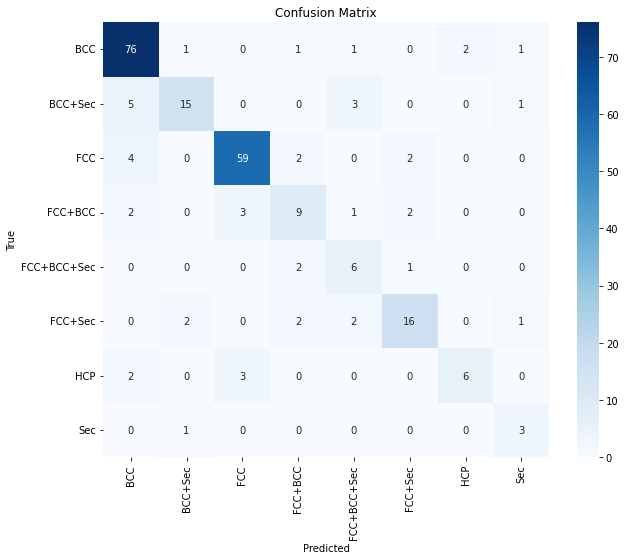

In [2]:
#####################################  Fine Tuning with Weeight Decay  ###################################
#    1. Load the pretrained model.
#    2. Create a custom dataset for the labeled data.
#    3. Fine-tune the model with a regression head.
#    4. Weight Decay for Layers

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainerCallback, IntervalStrategy


import torch
from torch.utils.data import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,
                          AdamW, get_linear_schedule_with_warmup)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
import re
import os

# Load the data
data = pd.read_csv('Final_Formated_and_cleaned_file_With_Features.csv')



###############  ['Co', '1.2', 'Fe', '0.8', 'Ni', '1'] 

# # Custom Tokenization
# def custom_tokenize(composition):
#     matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
#     tokens = []
#     for match in matches:
#         element, fraction = match
#         tokens.append(element)
#         tokens.append(fraction)
#     return tokens



def custom_tokenize(composition):
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    # Sort matches by the element's name to ensure alphabetical order
    sorted_matches = sorted(matches, key=lambda x: x[0])
    tokens = []
    for match in sorted_matches:
        element, fraction = match
        token = f"{element}{fraction}"  # Combine element and fraction
        tokens.append(token)
    return tokens

# Test the function
print(custom_tokenize("Co1.2 F0.8 Ni1"))  # Output should be: ['Co1.2', 'F0.8', 'Ni1']


data['tokenized_elements'] = data['composition'].apply(custom_tokenize)

# Label encode the 'Phase' column
label_encoder = LabelEncoder()
data['encoded_phase'] = label_encoder.fit_transform(data['Phase'])

# Normalize all numeric features and combine them with tokenized elements
feature_columns = [col for col in data.columns if col not in ['composition', 'Phase', 'tokenized_elements', 'encoded_phase']]
combined_features = data['tokenized_elements'].astype(str)
for feature in feature_columns:
    scaler = StandardScaler()
    normalized_feature = scaler.fit_transform(data[[feature]])
    data[f'normalized_{feature}'] = normalized_feature
    combined_features += ' ' + data[f'normalized_{feature}'].astype(str)
data['combined_features'] = combined_features

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained('./results/pretrained_BERT_200k')
model = AutoModelForSequenceClassification.from_pretrained('./results/pretrained_BERT_200k', num_labels=len(label_encoder.classes_))

if torch.cuda.is_available():
    model.cuda()

train_encodings = tokenizer([" ".join(tokens) for tokens in data_train['tokenized_elements'].to_list()], truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer([" ".join(tokens) for tokens in data_test['tokenized_elements'].to_list()], truncation=True, padding=True, max_length=512, return_tensors="pt")

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, data_train['encoded_phase'].values)
test_dataset = CustomDataset(test_encodings, data_test['encoded_phase'].values)


            
# def compute_metrics(p):
#     pred_labels = np.argmax(p.predictions, axis=1)
#     class_report = classification_report(p.label_ids, pred_labels, target_names=label_encoder.classes_, output_dict=True)
#     return {'classification_report': class_report, 'accuracy': accuracy_score(p.label_ids, pred_labels)}


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    #conf_matrix = confusion_matrix(p.label_ids, preds)
    #print("Confusion Matrix:")
    #print(conf_matrix)
    #sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')
    #plt.title('Confusion Matrix')
    #plt.show()
    return {'accuracy': accuracy_score(p.label_ids, preds)}

    

decay_layers = ["10", "11", "12"]
decay_param_names = [n for n, p in model.named_parameters() if any(f".{layer}." in n for layer in decay_layers)]
no_decay_param_names = [n for n, p in model.named_parameters() if n not in decay_param_names]
decay_params = [p for n, p in model.named_parameters() if n in decay_param_names]
no_decay_params = [p for n, p in model.named_parameters() if n in no_decay_param_names]
optimizer_grouped_parameters = [
    {"params": decay_params, "weight_decay": 0.01},
    {"params": no_decay_params, "weight_decay": 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5)
num_training_steps = len(train_dataset) * 30
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = './logs/' + current_time

training_args = TrainingArguments(
    output_dir='d:',
    num_train_epochs=12,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir=log_dir,
    logging_steps=1,
    save_steps=1,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)

)

trainer.train()

results = trainer.evaluate()
print(results)

# Get predictions and then compute the classification report for the best model
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Compute classification report
class_report_str = classification_report(predictions.label_ids, pred_labels, target_names=label_encoder.classes_)

# Print and save the classification report
print("Classification Report:\n", class_report_str)

# Save the classification report to ./results folder
with open('./results/classification_report.txt', 'w') as f:
    f.write(class_report_str)

# Get predictions and then compute the confusion matrix for the best model
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
conf_matrix = confusion_matrix(predictions.label_ids, pred_labels)

# Print and save the confusion matrix
print("Confusion Matrix:", conf_matrix)

# Save the confusion matrix to ./results folder
with open('./results/confusion_matrix.txt', 'w') as f:
    np.savetxt(f, conf_matrix, fmt='%d')

    
# Get predictions and then compute the classification report for the best model
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Compute classification report
class_report_str = classification_report(predictions.label_ids, pred_labels, target_names=label_encoder.classes_)

# Print and save the classification report
print("Classification Report:\n", class_report_str)

# Save the classification report to ./results folder
with open('./results/classification_report.txt', 'w') as f:
    f.write(class_report_str)

# Compute confusion matrix
conf_mat = confusion_matrix(predictions.label_ids, pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Save the confusion matrix to ./results folder
plt.savefig('./results/confusion_matrix.png', dpi=300)

# Show the plot
plt.show()    
    
tokenizer.save_pretrained('d:')
model.save_pretrained('d:')



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Confusion Matrix:
[[19  0 63  0  0  0  0  0]
 [ 3  0 21  0  0  0  0  0]
 [ 5  0 62  0  0  0  0  0]
 [ 1  0 16  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0]
 [ 4  0  7  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0]]


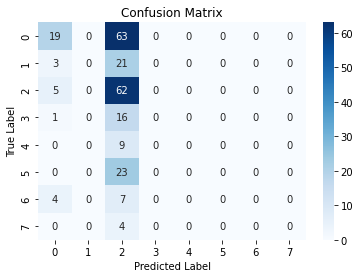

Confusion Matrix:
[[78  0  4  0  0  0  0  0]
 [23  0  1  0  0  0  0  0]
 [62  0  5  0  0  0  0  0]
 [16  0  1  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0]
 [22  0  1  0  0  0  0  0]
 [ 9  0  2  0  0  0  0  0]
 [ 3  0  1  0  0  0  0  0]]


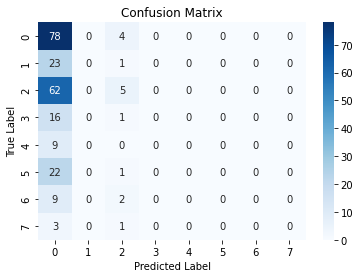

Confusion Matrix:
[[58 10  9  0  0  5  0  0]
 [ 2  5  2  0  0 15  0  0]
 [43  1 11  0  0 12  0  0]
 [ 0  0  2  0  0 15  0  0]
 [ 0  0  1  0  0  8  0  0]
 [ 0  3  7  0  0 13  0  0]
 [11  0  0  0  0  0  0  0]
 [ 0  1  2  0  0  1  0  0]]


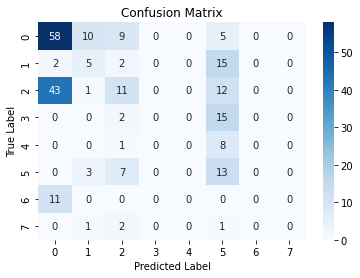

Confusion Matrix:
[[60  1 17  0  0  4  0  0]
 [ 7  0  2  0  0 15  0  0]
 [ 4  0 52  0  0 11  0  0]
 [ 0  2  4  0  0 11  0  0]
 [ 0  1  1  0  0  7  0  0]
 [ 0  1 10  0  0 12  0  0]
 [ 6  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0]]


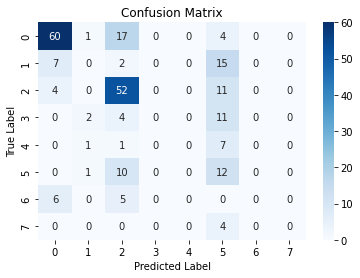

Confusion Matrix:
[[59 13  8  0  0  2  0  0]
 [ 3 21  0  0  0  0  0  0]
 [ 5 11 38  0  0 13  0  0]
 [ 0 16  0  0  0  1  0  0]
 [ 0  8  0  0  0  1  0  0]
 [ 0 12  1  0  0 10  0  0]
 [ 7  0  4  0  0  0  0  0]
 [ 0  3  0  0  0  1  0  0]]


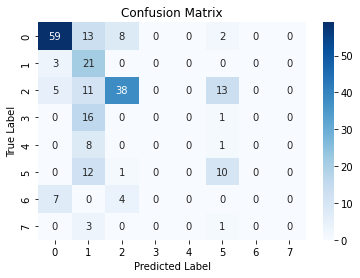

Confusion Matrix:
[[67  6  9  0  0  0  0  0]
 [ 4 16  4  0  0  0  0  0]
 [ 4  9 54  0  0  0  0  0]
 [ 0 14  3  0  0  0  0  0]
 [ 0  8  1  0  0  0  0  0]
 [ 0 12 11  0  0  0  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  3  1  0  0  0  0  0]]


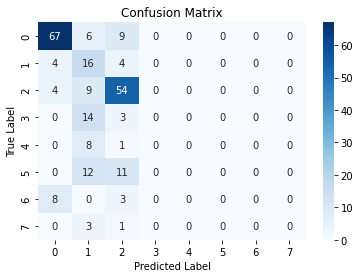

Confusion Matrix:
[[70  6  5  0  0  1  0  0]
 [ 5 18  0  0  0  1  0  0]
 [ 8  9 50  0  0  0  0  0]
 [ 0 11  3  0  0  3  0  0]
 [ 0  8  1  0  0  0  0  0]
 [ 0  9  8  0  0  6  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  3  0  0  0  1  0  0]]


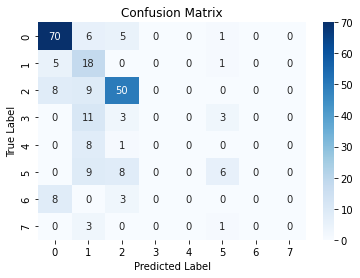

Confusion Matrix:
[[67  7  8  0  0  0  0  0]
 [ 3 21  0  0  0  0  0  0]
 [ 3  9 53  0  0  2  0  0]
 [ 0 15  1  0  0  1  0  0]
 [ 0  8  1  0  0  0  0  0]
 [ 0  9  7  0  0  7  0  0]
 [ 7  0  4  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


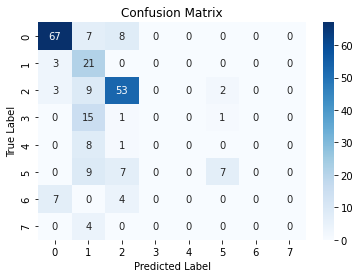

Confusion Matrix:
[[58 12  9  0  0  3  0  0]
 [ 2 16  0  0  0  6  0  0]
 [ 2  2 41  0  0 22  0  0]
 [ 0  8  0  0  0  9  0  0]
 [ 0  7  0  0  0  2  0  0]
 [ 0  8  0  0  0 15  0  0]
 [ 7  0  4  0  0  0  0  0]
 [ 0  3  0  0  0  1  0  0]]


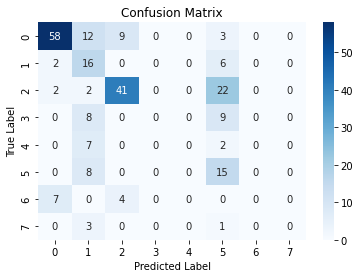

Confusion Matrix:
[[65 11  6  0  0  0  0  0]
 [ 3 20  0  1  0  0  0  0]
 [ 3  5 57  1  1  0  0  0]
 [ 0 14  3  0  0  0  0  0]
 [ 0  8  1  0  0  0  0  0]
 [ 0  9 14  0  0  0  0  0]
 [ 7  0  4  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


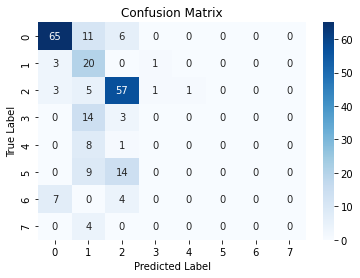

Confusion Matrix:
[[71  4  6  0  0  1  0  0]
 [ 5 15  4  0  0  0  0  0]
 [ 4  0 61  0  1  1  0  0]
 [ 0  6 10  0  1  0  0  0]
 [ 0  0  6  0  3  0  0  0]
 [ 0  4 15  0  2  2  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


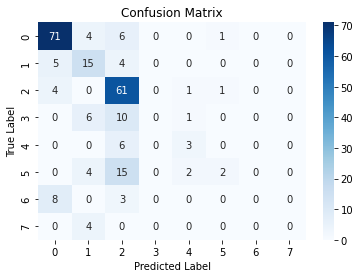

Confusion Matrix:
[[67  3 10  0  1  1  0  0]
 [ 3 15  3  1  2  0  0  0]
 [ 3  0 64  0  0  0  0  0]
 [ 0  2 10  0  1  4  0  0]
 [ 0  0  6  0  0  3  0  0]
 [ 0  2 12  1  0  8  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


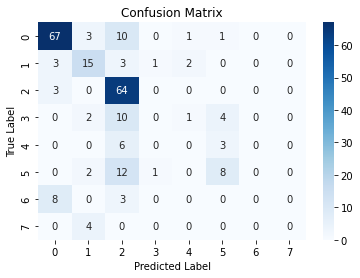

Confusion Matrix:
[[70  8  4  0  0  0  0  0]
 [ 4 19  0  0  1  0  0  0]
 [ 3  1 58  0  1  4  0  0]
 [ 0  9  4  0  2  2  0  0]
 [ 0  5  1  0  3  0  0  0]
 [ 0  6  8  0  3  6  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


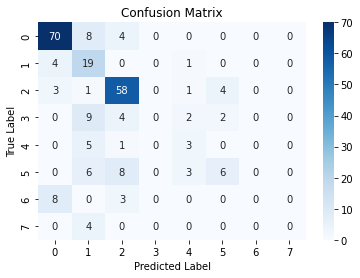

Confusion Matrix:
[[75  3  2  0  2  0  0  0]
 [ 8 14  0  0  2  0  0  0]
 [ 6  0 55  0  1  5  0  0]
 [ 3  4  6  0  3  1  0  0]
 [ 4  0  1  0  4  0  0  0]
 [ 1  5  5  0  3  9  0  0]
 [ 8  0  3  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0]]


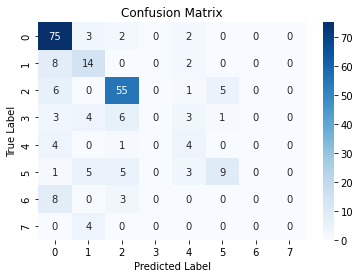

Confusion Matrix:
[[65 11  4  0  0  0  2  0]
 [ 3 20  0  1  0  0  0  0]
 [ 3  1 61  1  0  1  0  0]
 [ 0  7  8  2  0  0  0  0]
 [ 0  4  2  3  0  0  0  0]
 [ 0  5  7  3  0  8  0  0]
 [ 5  0  4  0  0  0  2  0]
 [ 0  4  0  0  0  0  0  0]]


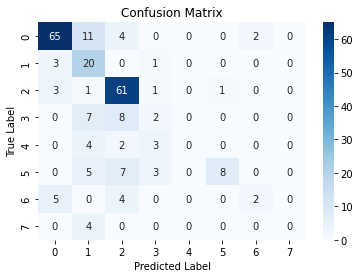

Confusion Matrix:
[[69  3  6  2  0  2  0  0]
 [ 5 13  2  2  0  2  0  0]
 [ 3  0 64  0  0  0  0  0]
 [ 0  1 12  3  0  1  0  0]
 [ 0  1  7  0  0  1  0  0]
 [ 0  3  8  1  0 11  0  0]
 [ 6  0  4  0  0  0  1  0]
 [ 0  3  0  0  0  1  0  0]]


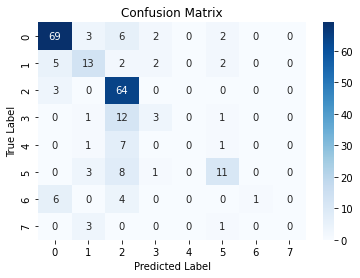

Confusion Matrix:
[[69  8  1  0  0  0  4  0]
 [ 3 21  0  0  0  0  0  0]
 [ 3  3 56  2  1  1  1  0]
 [ 2  7  5  1  2  0  0  0]
 [ 0  4  0  1  4  0  0  0]
 [ 0  7  4  1  2  9  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


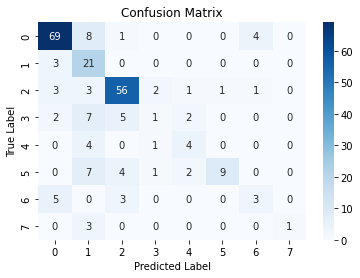

Confusion Matrix:
[[69  5  5  2  0  0  0  1]
 [ 3 19  0  0  0  2  0  0]
 [ 3  0 55  2  0  7  0  0]
 [ 0  3  3  6  0  5  0  0]
 [ 0  4  0  3  0  2  0  0]
 [ 0  4  1  5  0 13  0  0]
 [ 6  0  4  0  0  0  1  0]
 [ 0  3  0  0  0  0  0  1]]


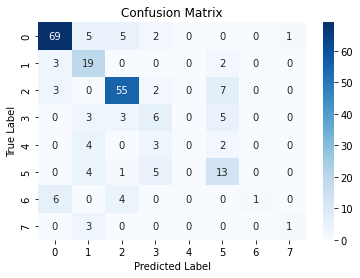

Confusion Matrix:
[[67  5  4  1  0  0  4  1]
 [ 3 19  0  2  0  0  0  0]
 [ 3  2 54  6  0  2  0  0]
 [ 2  4  0 11  0  0  0  0]
 [ 0  5  0  4  0  0  0  0]
 [ 0  5  1  8  0  7  0  2]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


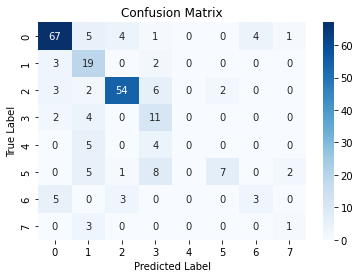

Confusion Matrix:
[[65  3  4  3  0  1  5  1]
 [ 3 17  0  2  0  2  0  0]
 [ 3  0 55  1  0  8  0  0]
 [ 0  1  4  4  0  8  0  0]
 [ 0  0  0  6  0  3  0  0]
 [ 0  2  4  1  1 15  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


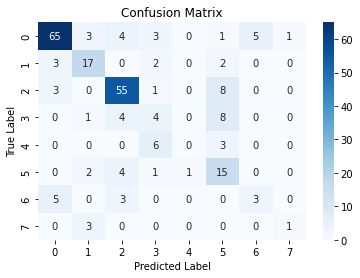

Confusion Matrix:
[[67  2  6  1  0  0  6  0]
 [ 3 18  2  1  0  0  0  0]
 [ 3  0 63  1  0  0  0  0]
 [ 1  4 11  1  0  0  0  0]
 [ 0  0  6  3  0  0  0  0]
 [ 0  2 16  3  0  2  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


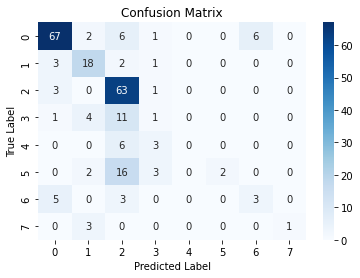

Confusion Matrix:
[[66  8  4  0  1  0  3  0]
 [ 3 21  0  0  0  0  0  0]
 [ 3  0 59  1  0  4  0  0]
 [ 0  7  5  2  1  2  0  0]
 [ 0  3  0  2  2  2  0  0]
 [ 0  4  5  1  2 11  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


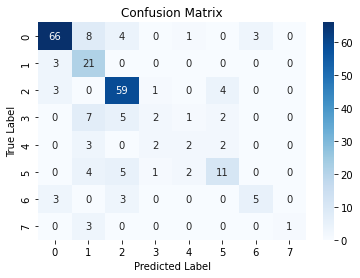

Confusion Matrix:
[[74  4  2  0  1  0  0  1]
 [ 3 21  0  0  0  0  0  0]
 [ 3  0 57  5  1  1  0  0]
 [ 2  1  3  5  5  1  0  0]
 [ 2  0  0  1  6  0  0  0]
 [ 0  2  6  1  6  8  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


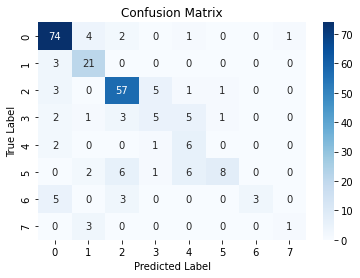

Confusion Matrix:
[[71  5  4  0  2  0  0  0]
 [ 3 20  0  1  0  0  0  0]
 [ 3  0 61  2  0  1  0  0]
 [ 0  4  7  2  3  1  0  0]
 [ 0  1  5  3  0  0  0  0]
 [ 0  3  5  2  2 11  0  0]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


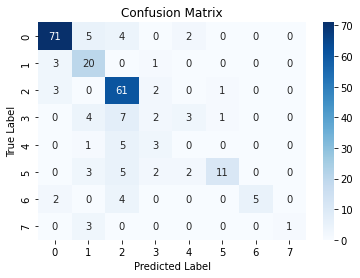

Confusion Matrix:
[[69  9  1  0  2  0  1  0]
 [ 3 19  0  0  0  2  0  0]
 [ 4  0 60  0  0  3  0  0]
 [ 0  4  7  1  0  5  0  0]
 [ 0  3  0  1  1  4  0  0]
 [ 0  3  3  1  1 15  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


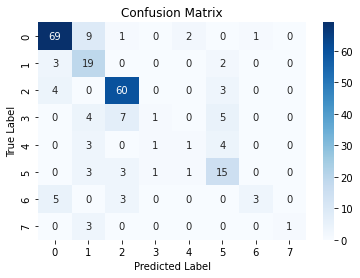

Confusion Matrix:
[[66  5  1  0  2  0  8  0]
 [ 4 19  0  0  1  0  0  0]
 [ 3  0 60  2  1  0  1  0]
 [ 1  5  5  3  2  1  0  0]
 [ 0  0  1  4  4  0  0  0]
 [ 1  2  6  2  4  8  0  0]
 [ 2  0  3  0  0  0  6  0]
 [ 0  3  0  0  0  0  0  1]]


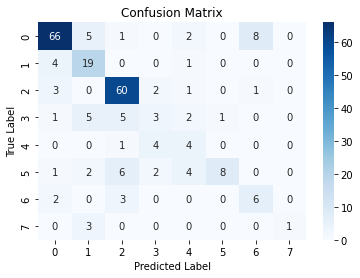

Confusion Matrix:
[[64  3  4  1  2  1  7  0]
 [ 3 18  0  0  1  2  0  0]
 [ 2  0 61  1  0  2  1  0]
 [ 0  2  8  3  1  3  0  0]
 [ 0  0  3  1  3  2  0  0]
 [ 0  2  3  2  2 14  0  0]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


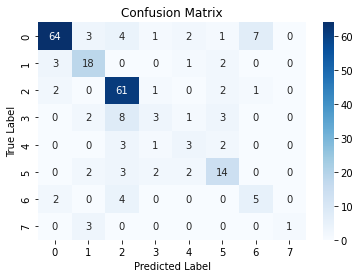

Confusion Matrix:
[[72  4  2  1  1  0  2  0]
 [ 7 13  0  1  3  0  0  0]
 [ 3  0 62  2  0  0  0  0]
 [ 2  1  8  3  2  1  0  0]
 [ 0  1  1  4  3  0  0  0]
 [ 2  1  8  4  0  8  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


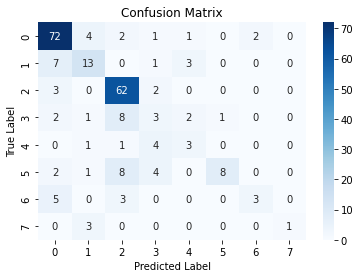

Confusion Matrix:
[[63  9  3  0  2  0  5  0]
 [ 3 18  0  1  2  0  0  0]
 [ 3  0 57  5  0  2  0  0]
 [ 0  4  1  7  3  2  0  0]
 [ 0  1  0  1  4  3  0  0]
 [ 0  2  4  1  3 13  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


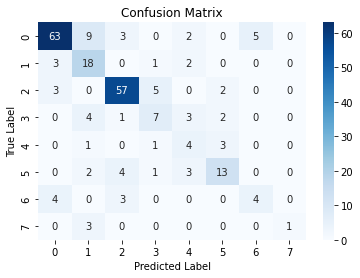

Confusion Matrix:
[[69  6  2  0  2  0  3  0]
 [ 3 21  0  0  0  0  0  0]
 [ 3  0 57  3  1  3  0  0]
 [ 0  4  2  6  4  1  0  0]
 [ 0  1  1  1  5  1  0  0]
 [ 0  2  5  1  4 11  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


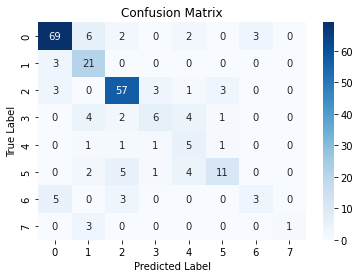

Confusion Matrix:
[[66  5  4  0  3  0  4  0]
 [ 3 18  0  0  3  0  0  0]
 [ 3  0 61  3  0  0  0  0]
 [ 0  0  7  4  5  1  0  0]
 [ 0  1  3  2  3  0  0  0]
 [ 0  2  8  2  3  8  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


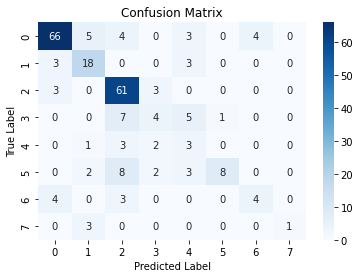

Confusion Matrix:
[[72  5  2  0  1  0  2  0]
 [ 5 18  0  0  1  0  0  0]
 [ 4  0 58  3  0  2  0  0]
 [ 2  1  4  5  4  1  0  0]
 [ 0  1  3  2  3  0  0  0]
 [ 1  3  4  1  2 12  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


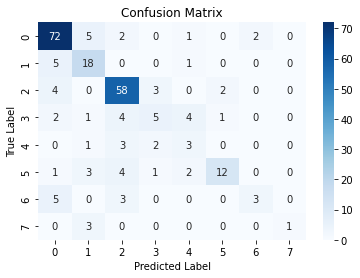

Confusion Matrix:
[[71  4  0  1  1  0  5  0]
 [ 3 19  0  0  2  0  0  0]
 [ 4  0 59  2  0  2  0  0]
 [ 1  2  3  6  4  1  0  0]
 [ 0  1  1  2  4  1  0  0]
 [ 0  3  4  1  3 11  0  1]
 [ 3  0  4  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


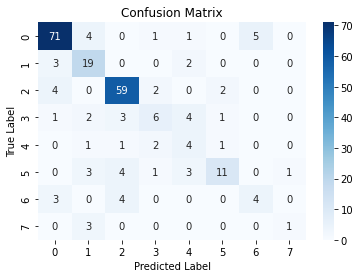

Confusion Matrix:
[[69  4  5  1  2  0  1  0]
 [ 3 19  0  0  2  0  0  0]
 [ 3  0 58  3  0  3  0  0]
 [ 1  2  3  4  3  4  0  0]
 [ 0  3  0  1  3  2  0  0]
 [ 0  1  5  1  6  9  0  1]
 [ 4  0  4  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


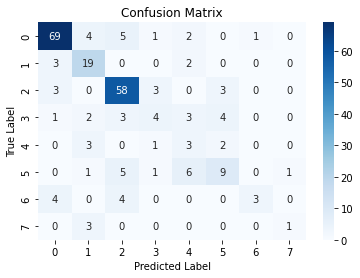

Confusion Matrix:
[[73  4  1  0  1  0  3  0]
 [ 6 16  0  0  2  0  0  0]
 [ 3  0 61  3  0  0  0  0]
 [ 2  1  6  3  2  3  0  0]
 [ 0  2  2  0  4  1  0  0]
 [ 1  3  9  0  3  7  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


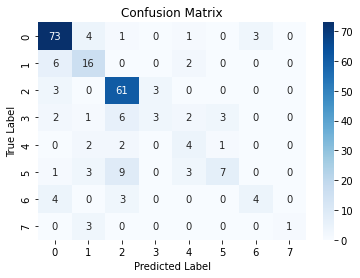

Confusion Matrix:
[[65  7  6  0  2  0  2  0]
 [ 3 20  0  0  1  0  0  0]
 [ 3  0 58  3  0  3  0  0]
 [ 1  2  1  7  3  3  0  0]
 [ 0  2  0  2  4  1  0  0]
 [ 0  2  4  1  2 13  0  1]
 [ 3  0  4  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


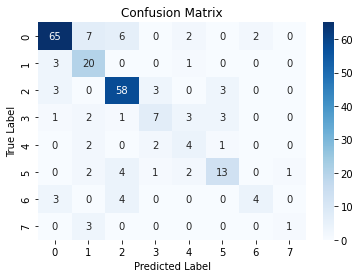

Confusion Matrix:
[[71  4  2  1  1  0  3  0]
 [ 4 19  0  0  1  0  0  0]
 [ 3  0 53  7  0  4  0  0]
 [ 1  3  1  7  3  2  0  0]
 [ 0  3  0  2  4  0  0  0]
 [ 0  4  4  3  3  9  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


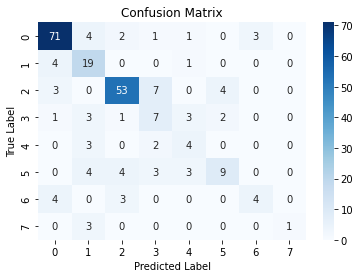

Confusion Matrix:
[[67  2  6  2  1  2  2  0]
 [ 4 13  0  1  2  3  0  1]
 [ 3  0 63  0  0  1  0  0]
 [ 0  0 10  3  2  2  0  0]
 [ 0  0  3  3  2  1  0  0]
 [ 0  0  7  2  2 12  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


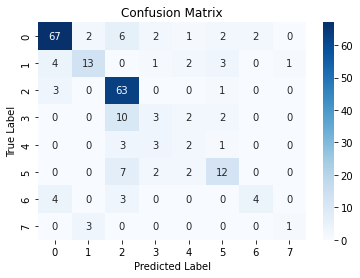

Confusion Matrix:
[[74  5  0  0  0  0  3  0]
 [ 3 20  0  0  1  0  0  0]
 [ 3  0 61  2  0  1  0  0]
 [ 1  2  6  6  2  0  0  0]
 [ 0  3  1  2  3  0  0  0]
 [ 1  6  9  1  1  5  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


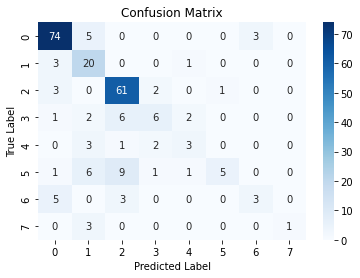

Confusion Matrix:
[[69  3  3  3  1  1  2  0]
 [ 3 15  0  0  4  2  0  0]
 [ 1  0 64  0  0  1  1  0]
 [ 0  0  5  6  2  4  0  0]
 [ 0  0  1  3  4  1  0  0]
 [ 0  1  8  2  2 10  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


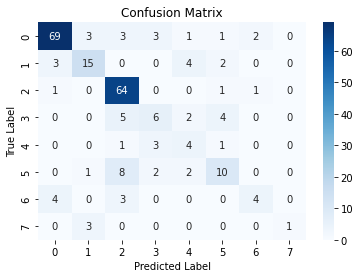

Confusion Matrix:
[[75  3  2  0  1  0  1  0]
 [ 5 14  0  0  5  0  0  0]
 [ 3  0 58  3  0  3  0  0]
 [ 1  2  3  6  2  3  0  0]
 [ 0  1  0  3  5  0  0  0]
 [ 0  1  8  1  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


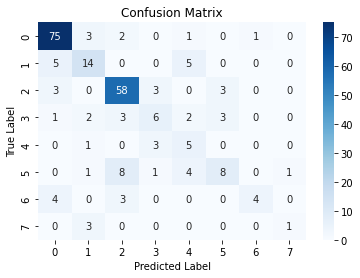

Confusion Matrix:
[[70  4  1  0  1  0  6  0]
 [ 5 13  0  0  4  1  0  1]
 [ 2  0 59  1  0  4  1  0]
 [ 0  2  7  3  2  3  0  0]
 [ 0  0  2  0  5  2  0  0]
 [ 0  1  4  1  4 12  0  1]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


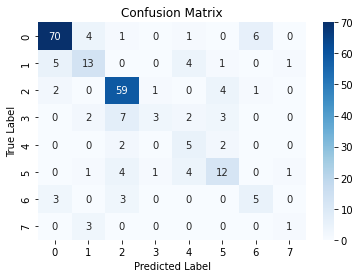

Confusion Matrix:
[[71  4  1  1  0  0  5  0]
 [ 5 14  0  0  5  0  0  0]
 [ 3  0 62  1  0  1  0  0]
 [ 0  2  7  6  1  1  0  0]
 [ 0  0  1  6  2  0  0  0]
 [ 0  2  6  3  3  9  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


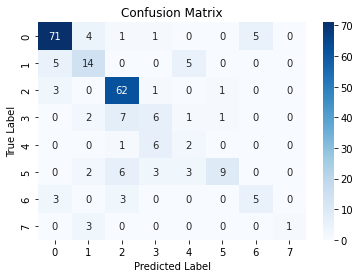

Confusion Matrix:
[[73  4  2  0  1  0  2  0]
 [ 3 15  0  0  5  0  0  1]
 [ 3  0 63  1  0  0  0  0]
 [ 1  1  6  6  2  1  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  9  1  4  7  0  1]
 [ 3  0  3  0  0  0  5  0]
 [ 0  2  0  0  0  0  0  2]]


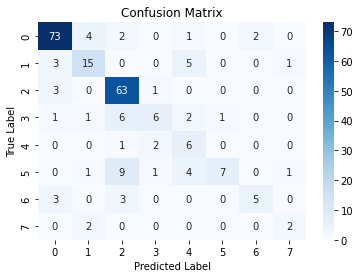

Confusion Matrix:
[[66  6  5  1  1  0  3  0]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 54  4  0  6  0  0]
 [ 0  1  3  7  2  4  0  0]
 [ 0  0  0  2  5  2  0  0]
 [ 0  1  3  1  5 12  0  1]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


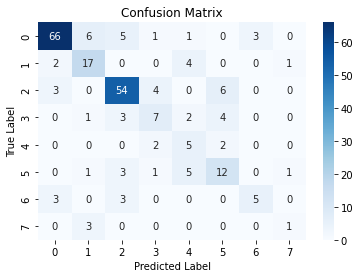

Confusion Matrix:
[[70  5  2  0  1  0  4  0]
 [ 3 17  0  0  4  0  0  0]
 [ 3  0 58  2  0  4  0  0]
 [ 1  1  4  8  2  1  0  0]
 [ 0  0  0  3  6  0  0  0]
 [ 0  3  8  2  3  7  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


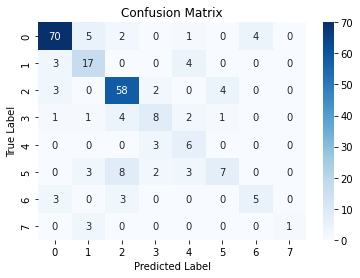

Confusion Matrix:
[[65  6  3  3  0  0  5  0]
 [ 2 15  0  1  3  0  0  3]
 [ 3  0 60  1  0  3  0  0]
 [ 0  1  5  6  2  3  0  0]
 [ 0  0  1  4  3  1  0  0]
 [ 0  0  8  4  2  9  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  2  0  0  0  0  0  2]]


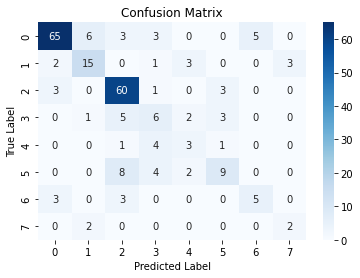

Confusion Matrix:
[[71  3  1  0  2  0  5  0]
 [ 3 16  0  0  4  0  0  1]
 [ 3  0 59  0  0  5  0  0]
 [ 0  2  5  6  1  3  0  0]
 [ 0  0  1  3  4  1  0  0]
 [ 0  1  5  1  3 13  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


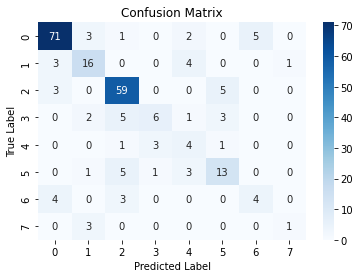

Confusion Matrix:
[[64  5  3  2  2  0  6  0]
 [ 2 16  0  1  4  0  0  1]
 [ 3  0 60  1  0  3  0  0]
 [ 0  2  5  8  1  1  0  0]
 [ 0  1  1  3  4  0  0  0]
 [ 0  1  4  3  3 12  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


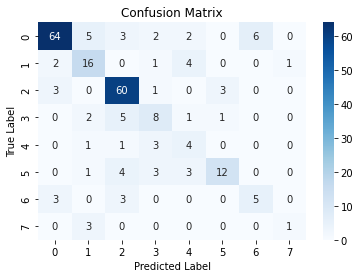

Confusion Matrix:
[[69  7  1  0  1  0  4  0]
 [ 3 18  0  0  3  0  0  0]
 [ 3  0 61  1  0  2  0  0]
 [ 0  2  5  5  1  4  0  0]
 [ 0  1  1  0  6  1  0  0]
 [ 0  2  5  1  3 11  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


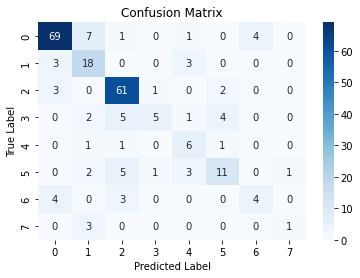

Confusion Matrix:
[[66  4  7  1  0  0  4  0]
 [ 4 16  0  0  4  0  0  0]
 [ 3  0 63  1  0  0  0  0]
 [ 0  1  7  6  2  1  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  0  9  4  3  7  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


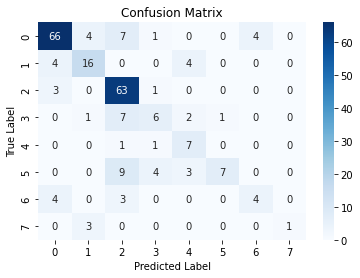

Confusion Matrix:
[[65  5  2  0  0  2  8  0]
 [ 3 16  0  0  1  3  0  1]
 [ 3  0 63  1  0  0  0  0]
 [ 0  2  7  6  0  2  0  0]
 [ 0  0  1  2  5  1  0  0]
 [ 0  0  9  1  3  8  0  2]
 [ 3  0  3  0  0  0  5  0]
 [ 0  2  0  0  0  0  0  2]]


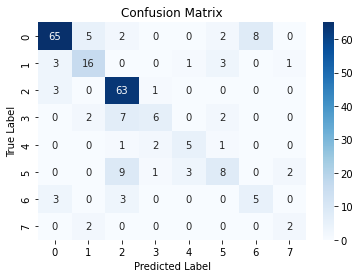

Confusion Matrix:
[[64  6  2  1  0  1  8  0]
 [ 2 18  0  1  3  0  0  0]
 [ 3  0 56  3  0  5  0  0]
 [ 0  2  4  8  0  3  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  2  4  4  3 10  0  0]
 [ 3  0  3  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


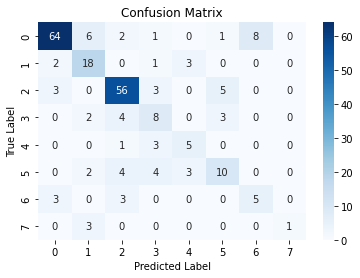

Confusion Matrix:
[[70  6  2  0  1  1  2  0]
 [ 3 15  0  0  5  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  1  3  7  3  2  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  1  6  0  6  9  0  1]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


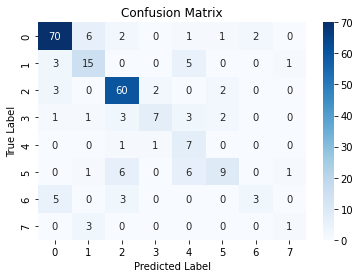

Confusion Matrix:
[[68  6  6  1  0  0  1  0]
 [ 4 14  0  0  4  0  0  2]
 [ 3  0 63  0  0  1  0  0]
 [ 0  2  6  6  1  2  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  1  8  3  3  7  0  1]
 [ 4  0  4  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


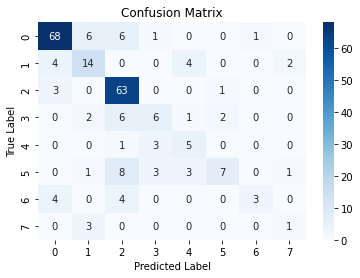

Confusion Matrix:
[[66  6  6  0  1  1  2  0]
 [ 2 19  0  0  2  0  0  1]
 [ 3  0 62  1  0  1  0  0]
 [ 0  2  3  8  2  2  0  0]
 [ 0  1  1  1  6  0  0  0]
 [ 0  1  6  2  4  9  0  1]
 [ 4  0  4  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


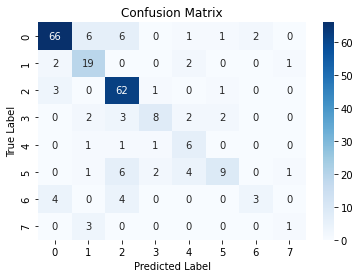

Confusion Matrix:
[[67  4  3  1  1  0  6  0]
 [ 4 15  0  0  3  0  0  2]
 [ 3  0 63  1  0  0  0  0]
 [ 0  2  5  7  2  1  0  0]
 [ 0  1  1  3  4  0  0  0]
 [ 0  1  9  2  4  6  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


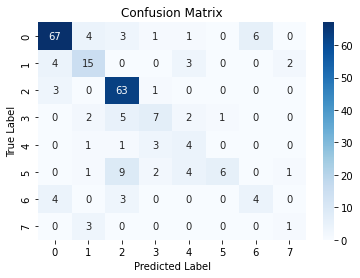

Confusion Matrix:
[[67  5  0  1  0  1  7  1]
 [ 2 19  0  0  3  0  0  0]
 [ 3  0 63  1  0  0  0  0]
 [ 0  1  5  5  1  5  0  0]
 [ 0  0  1  2  5  1  0  0]
 [ 0  1  8  1  4  9  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


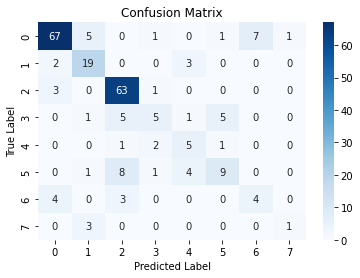

Confusion Matrix:
[[66  5  5  2  1  1  2  0]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 59  2  0  3  0  0]
 [ 0  1  3  7  2  4  0  0]
 [ 0  0  1  4  4  0  0  0]
 [ 0  0  6  2  4  9  0  2]
 [ 5  0  3  0  0  0  3  0]
 [ 0  2  0  0  0  0  0  2]]


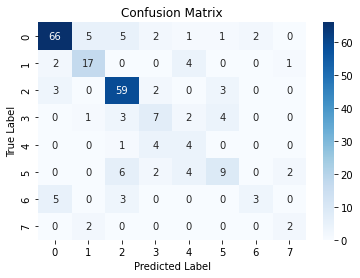

Confusion Matrix:
[[70  4  4  1  0  0  3  0]
 [ 4 18  0  0  2  0  0  0]
 [ 3  0 63  1  0  0  0  0]
 [ 0  2  6  5  1  3  0  0]
 [ 0  1  1  5  1  1  0  0]
 [ 0  2  9  2  3  7  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


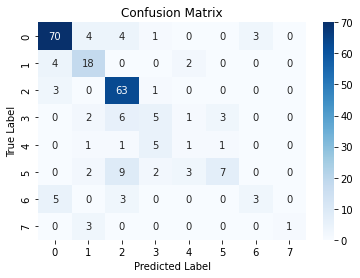

Confusion Matrix:
[[65  5  5  2  0  1  3  1]
 [ 2 17  0  1  3  0  0  1]
 [ 3  0 62  1  0  1  0  0]
 [ 0  1  4  8  2  2  0  0]
 [ 0  1  1  1  6  0  0  0]
 [ 0  0  8  4  3  8  0  0]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


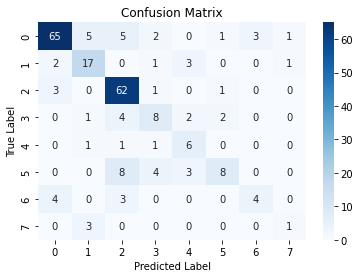

Confusion Matrix:
[[70  5  2  2  0  1  2  0]
 [ 2 18  0  0  4  0  0  0]
 [ 3  0 59  1  0  4  0  0]
 [ 1  2  4  6  1  3  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  0  6  3  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


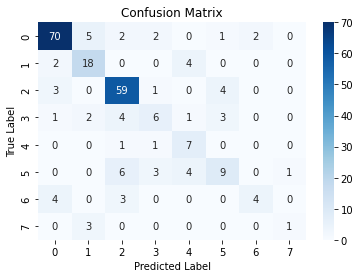

Confusion Matrix:
[[69  4  3  2  0  1  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  1  0  3  0  0]
 [ 0  1  5  6  2  3  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  0  6  3  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


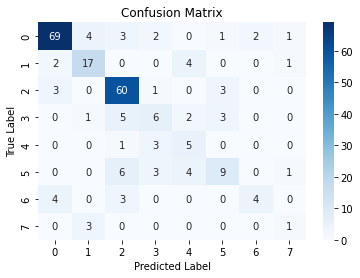

Confusion Matrix:
[[70  5  0  1  0  1  5  0]
 [ 3 17  0  0  4  0  0  0]
 [ 3  0 62  1  0  1  0  0]
 [ 0  1  4  7  2  3  0  0]
 [ 0  0  1  2  5  1  0  0]
 [ 0  0  8  2  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


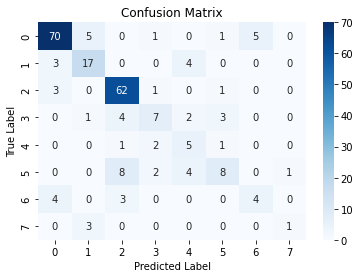

Confusion Matrix:
[[72  4  1  2  0  0  3  0]
 [ 3 17  0  0  4  0  0  0]
 [ 3  0 61  2  0  1  0  0]
 [ 1  1  4  6  3  2  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  2  7  2  3  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


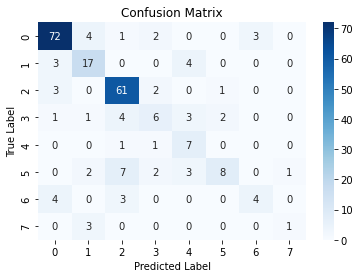

Confusion Matrix:
[[67  4  7  2  0  0  2  0]
 [ 4 15  0  0  3  1  0  1]
 [ 3  0 62  1  0  1  0  0]
 [ 0  1  4  8  2  2  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  1  9  3  3  6  0  1]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


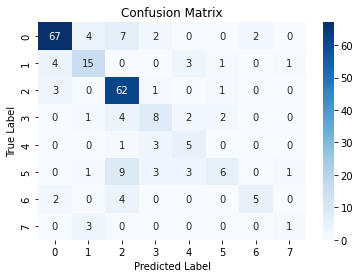

Confusion Matrix:
[[68  4  5  2  0  0  3  0]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  1  0  3  0  0]
 [ 0  2  4  7  1  3  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  0  4  3  4 11  0  1]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


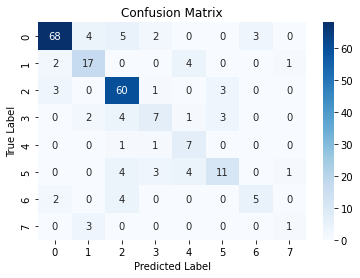

Confusion Matrix:
[[69  4  1  2  0  0  5  1]
 [ 2 16  0  0  4  0  0  2]
 [ 3  0 62  1  0  1  0  0]
 [ 0  2  4  7  1  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


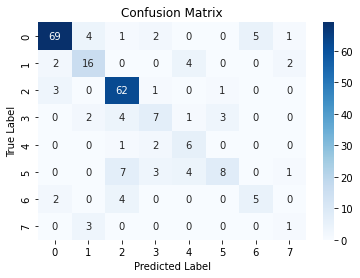

Confusion Matrix:
[[70  4  2  2  0  0  3  1]
 [ 2 20  0  0  2  0  0  0]
 [ 3  0 60  1  0  3  0  0]
 [ 0  2  3 10  1  1  0  0]
 [ 0  1  1  1  6  0  0  0]
 [ 0  2  5  2  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


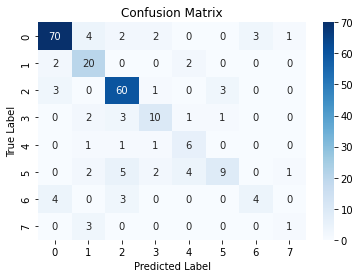

Confusion Matrix:
[[66  4  4  2  0  0  5  1]
 [ 2 19  0  0  3  0  0  0]
 [ 3  0 61  1  0  2  0  0]
 [ 1  2  4  7  1  2  0  0]
 [ 0  0  1  1  7  0  0  0]
 [ 0  2  7  2  4  7  0  1]
 [ 2  0  4  0  0  0  5  0]
 [ 0  3  0  0  0  0  0  1]]


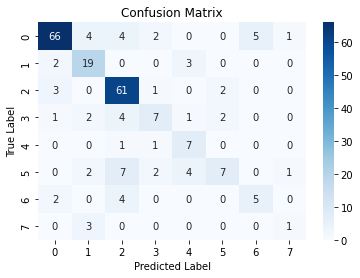

Confusion Matrix:
[[67  4  5  2  1  0  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  2  3  9  1  1  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  7  2  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


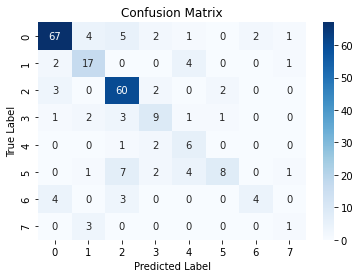

Confusion Matrix:
[[67  4  5  2  0  1  2  1]
 [ 2 16  0  0  3  0  0  3]
 [ 3  0 58  2  0  4  0  0]
 [ 1  2  4  6  1  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  3  3  3 12  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  2  0  0  0  0  0  2]]


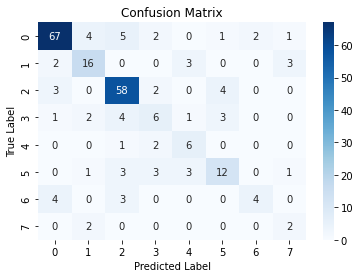

Confusion Matrix:
[[69  3  3  2  0  1  3  1]
 [ 3 17  0  0  2  0  0  2]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  1  4  2  3 12  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


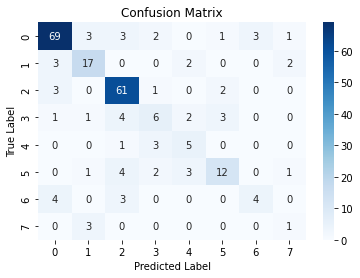

Confusion Matrix:
[[69  3  3  2  0  1  3  1]
 [ 3 17  0  0  3  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  1  4  7  2  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  7  1  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


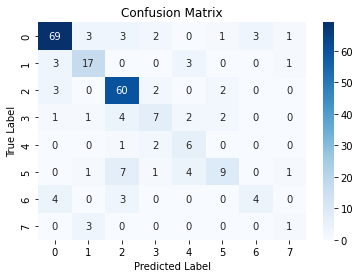

Confusion Matrix:
[[67  4  4  2  1  0  3  1]
 [ 2 18  0  0  3  0  0  1]
 [ 3  0 59  2  0  3  0  0]
 [ 1  2  4  6  2  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  3  1  4 13  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


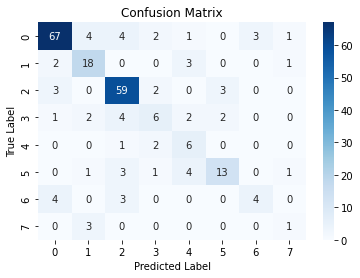

Confusion Matrix:
[[64  4  4  2  0  1  6  1]
 [ 2 18  0  0  3  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  1  8  1  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


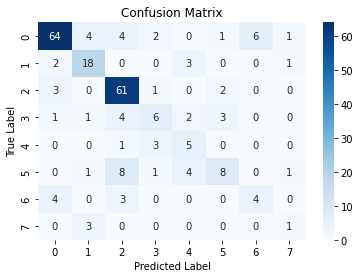

Confusion Matrix:
[[66  4  5  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  1  4  6  3  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  5  2  4 10  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


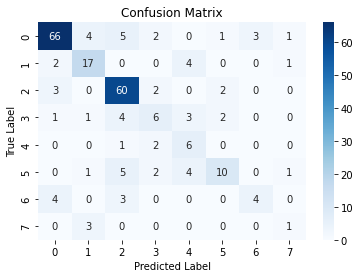

Confusion Matrix:
[[64  4  5  2  0  1  5  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  3  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  9  3  4  6  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


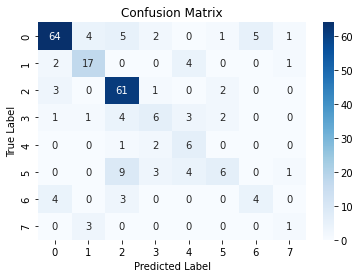

Confusion Matrix:
[[65  4  5  2  0  1  4  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  9  1  4  7  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


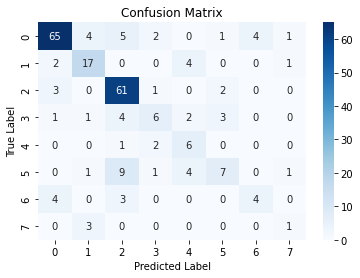

Confusion Matrix:
[[68  4  4  2  1  0  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  1  4  6  3  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  5  2  4 10  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


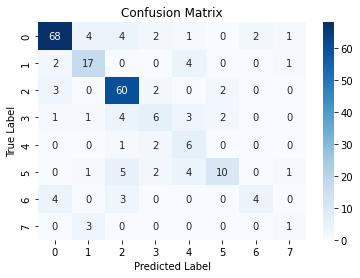

Confusion Matrix:
[[69  4  3  2  1  0  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  7  2  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  8  3  4  7  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


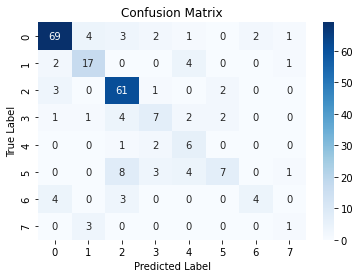

Confusion Matrix:
[[69  4  3  2  1  0  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 60  2  0  2  0  0]
 [ 1  2  4  6  2  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  6  2  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


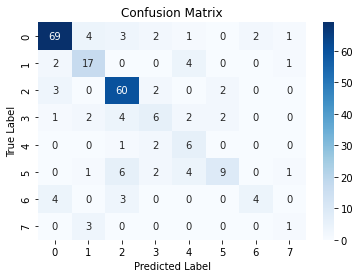

Confusion Matrix:
[[70  4  2  2  0  1  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  3  2  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  2  4  9  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


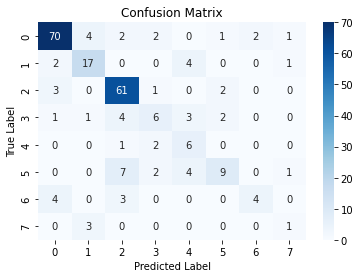

Confusion Matrix:
[[69  4  3  2  0  1  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  8  3  4  7  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


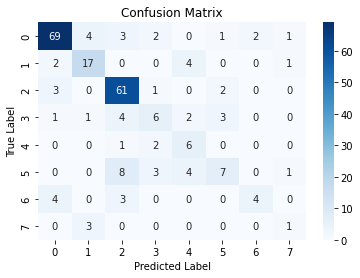

Confusion Matrix:
[[68  4  3  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 0  1  4  7  2  3  0  0]
 [ 0  0  1  3  5  0  0  0]
 [ 0  0  9  3  4  6  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


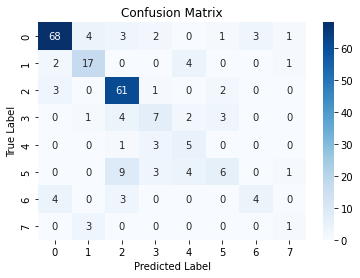

Confusion Matrix:
[[69  4  1  2  0  1  4  1]
 [ 2 17  0  0  3  1  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  8  2  4  7  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


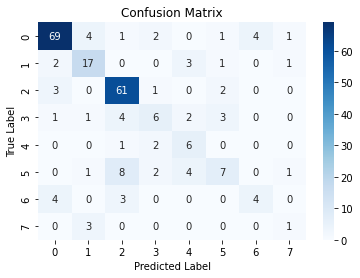

Confusion Matrix:
[[70  4  1  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  7  2  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


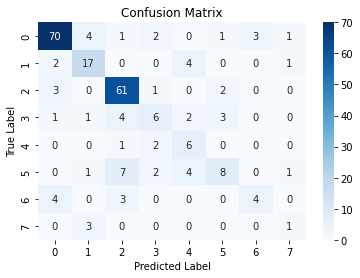

Confusion Matrix:
[[69  4  3  2  0  1  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


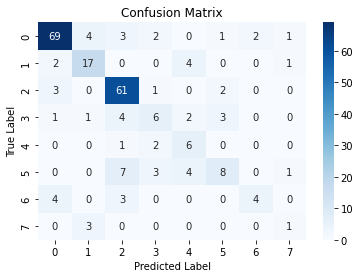

Confusion Matrix:
[[71  3  2  2  0  1  2  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


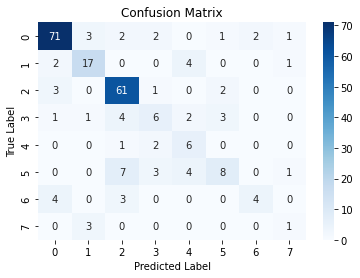

Confusion Matrix:
[[71  3  1  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  1  7  2  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


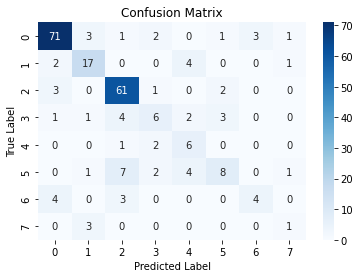

Confusion Matrix:
[[70  4  1  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


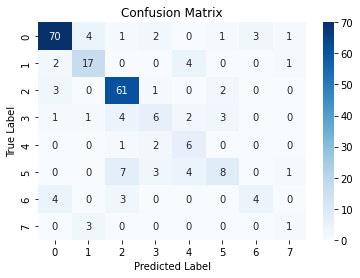

Confusion Matrix:
[[70  4  1  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


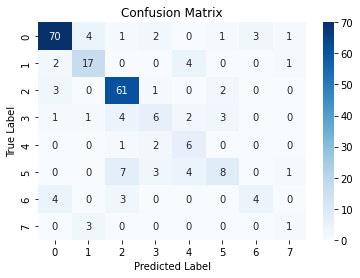

Confusion Matrix:
[[70  4  1  2  0  1  3  1]
 [ 2 17  0  0  4  0  0  1]
 [ 3  0 61  1  0  2  0  0]
 [ 1  1  4  6  2  3  0  0]
 [ 0  0  1  2  6  0  0  0]
 [ 0  0  7  3  4  8  0  1]
 [ 4  0  3  0  0  0  4  0]
 [ 0  3  0  0  0  0  0  1]]


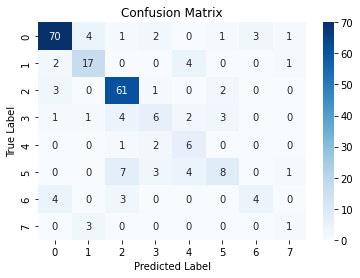

Confusion Matrix:
[[65  3  4  3  0  1  5  1]
 [ 3 17  0  2  0  2  0  0]
 [ 3  0 55  1  0  8  0  0]
 [ 0  1  4  4  0  8  0  0]
 [ 0  0  0  6  0  3  0  0]
 [ 0  2  4  1  1 15  0  0]
 [ 5  0  3  0  0  0  3  0]
 [ 0  3  0  0  0  0  0  1]]


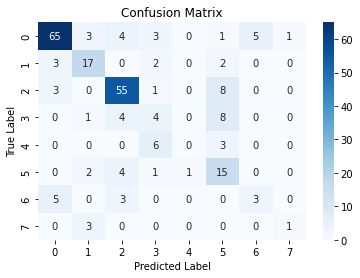

{'eval_loss': 0.8770548701286316, 'eval_accuracy': 0.6751054852320675, 'eval_runtime': 0.8981, 'eval_samples_per_second': 263.894, 'eval_steps_per_second': 2.227, 'epoch': 31.0}


In [18]:
########################### Train from Scratch #####################


import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
import re
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the data
data = pd.read_csv('Final_Formated_and_cleaned_file_With_Features.csv')  # Final_Formated_and_cleaned_file.csv is without features

# Custom Tokenization
def custom_tokenize(composition):
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    tokens = []
    for match in matches:
        element, fraction = match
        tokens.append(element)
        tokens.append(fraction)
    return tokens

data['tokenized_elements'] = data['composition'].apply(custom_tokenize)

# Label Encode the 'Phase' column
label_encoder = LabelEncoder()
data['encoded_phase'] = label_encoder.fit_transform(data['Phase'])

# Normalize other features and concatenate
feature_columns = [col for col in data.columns if col not in ['composition', 'Phase', 'tokenized_elements', 'encoded_phase']]
combined_features = data['tokenized_elements'].astype(str)
for feature in feature_columns:
    combined_features += ' ' + data[feature].astype(str)

data['combined_features'] = combined_features

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

if torch.cuda.is_available():
    model.cuda()

train_encodings = tokenizer(data_train['combined_features'].to_list(), truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(data_test['combined_features'].to_list(), truncation=True, padding=True, max_length=512, return_tensors="pt")

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # <-- Change here
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, data_train['encoded_phase'].values)
test_dataset = CustomDataset(test_encodings, data_test['encoded_phase'].values)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    conf_matrix = confusion_matrix(p.label_ids, preds)
    print("Confusion Matrix:")
    print(conf_matrix)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    return {'accuracy': accuracy_score(p.label_ids, preds)}

current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = './logs/' + current_time

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=15,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir=log_dir,
    logging_steps=10,
    save_steps=200,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    report_to='tensorboard'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate()
print(results)

import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=y.unique(), yticklabels=y.unique())
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Save tokenizer and label encoder
tokenizer.save_pretrained('./results')
torch.save(label_encoder, './results/label_encoder.pkl')



In [ ]:
####################################### FINE TUNNING SECTION ##########################################

Some weights of the model checkpoint at ./results were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


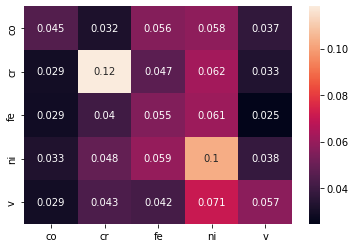

In [50]:
######################Attention Map Trained Model####################################

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel

# Load your trained model and tokenizer
model_path = './results'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path, output_attentions=True)

# Ensure model is in evaluation mode
model.eval()

# Tokenize
inputs = tokenizer("Co Cr Fe Ni V", return_tensors="pt", add_special_tokens=True)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# Get Attention Weights
outputs = model(**inputs)
attentions = outputs.attentions  # List of attention weights for each layer

# Aggregate across all heads for simplicity (could be refined)
avg_attention = attentions[-1].squeeze(0).mean(0).detach().numpy()

# Exclude the [CLS] and [SEP] tokens
avg_attention = avg_attention[1:-1, 1:-1]

# Visualize
labels = [tokenizer.decode([id]) for id in input_ids[0]][1:-1]  # Also exclude [CLS] and [SEP] from labels
sns.heatmap(avg_attention, annot=True, xticklabels=labels, yticklabels=labels)
plt.show()


In [56]:
###################### Interpret the results LIME Approach TEST own Composition ###################


from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Load the data
data = pd.read_csv('Final_Formated_and_cleaned_file_No_Features.csv')

# To mitigate the problem of Element order
import re

def extract_and_sort_elements(composition):
    # Extract elements and their proportions using regex
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    
    # Sort by element name
    sorted_matches = sorted(matches, key=lambda x: x[0])
    
    # Reconstruct the sorted composition
    sorted_composition = ' '.join([''.join(pair) for pair in sorted_matches])
    
    return sorted_composition


data['sorted_elements'] = data['composition'].apply(extract_and_sort_elements)
le = LabelEncoder()
data['encoded_phase'] = le.fit_transform(data['Phase'])
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)


# 1. Load the pretrained model and tokenizer
model_path = './results' # Directory where the best model weights were saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ensure model is in evaluation mode
model.eval()

# If using GPU
if torch.cuda.is_available():
    model = model.cuda()


##########################    Main LIME Script      #########################


from lime.lime_text import LimeTextExplainer

def predictor(texts):
    device = model.device  # get the device of the model
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    encodings = {key: val.to(device) for key, val in encodings.items()}  # move encodings to the same device
    with torch.no_grad():
        outputs = model(**encodings)
    return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

your_composition = "Co1 Cr1 Fe1 Mn1 Ni0.8 V1.2"
sorted_composition = extract_and_sort_elements(your_composition)  # Convert to alphabetical order
sample_text = sorted_composition  # Use the sorted composition for LIME

explainer = LimeTextExplainer(class_names=le.classes_)
explanation = explainer.explain_instance(sample_text, predictor, num_features=len(data['encoded_phase'].unique()), top_labels=6)

explanation.show_in_notebook(text=sample_text)
explanation.save_to_file('A_explanation_output.html')

In [65]:
##modified to ensure that LIME treats the element and its coefficient as a single entity###
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
import os
import re
from lime.lime_text import LimeTextExplainer

# Load the data
data = pd.read_csv('Final_Formated_and_cleaned_file_No_Features.csv')

def extract_and_sort_elements(composition):
    # Extract elements and their proportions using regex
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    
    # Sort by element name
    sorted_matches = sorted(matches, key=lambda x: x[0])
    
    # Reconstruct the sorted composition
    sorted_composition = ' '.join([''.join(pair) for pair in sorted_matches])
    
    return sorted_composition

data['sorted_elements'] = data['composition'].apply(extract_and_sort_elements)
le = LabelEncoder()
data['encoded_phase'] = le.fit_transform(data['Phase'])
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Load the pretrained model and tokenizer
model_path = './results'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ensure model is in evaluation mode
model.eval()

# If using GPU
if torch.cuda.is_available():
    model = model.cuda()

def predictor(texts):
    device = model.device  # get the device of the model
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    encodings = {key: val.to(device) for key, val in encodings.items()}  # move encodings to the same device
    with torch.no_grad():
        outputs = model(**encodings)
    return torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()

# Custom splitter for LIME to treat element and coefficient as a single entity
def custom_split(text):
    return re.findall(r'([A-Z][a-z]*[0-9.]+)', text)

your_composition = "Cr1 Fe1 Ni0.9"
sorted_composition = extract_and_sort_elements(your_composition)
sample_text = sorted_composition

explainer = LimeTextExplainer(class_names=le.classes_, split_expression=custom_split)
explanation = explainer.explain_instance(sample_text, predictor, num_features=len(data['encoded_phase'].unique()), top_labels=8)

explanation.show_in_notebook(text=sample_text)
explanation.save_to_file('A_explanation_output.html')


In [55]:
########################################### PREDICTIONS #####################################
# With Probabilities
#Convert Input Composition to alphabetical Order
# Go to Results folder in use/Sps/results
#Copy from checkpoint to results folder the best weights


from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Load the data
data = pd.read_csv('Final_Formated_and_cleaned_file_No_Features.csv')

# To mitigate the problem of Element order
import re

def custom_tokenize(composition):
    # Extract elements and their proportions using regex
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    
    # Sort by element name
    sorted_matches = sorted(matches, key=lambda x: x[0])
    
    # Return the sorted composition as a list of tokens
    tokens = [''.join(pair) for pair in sorted_matches]
    
    return tokens

data['tokenized_elements'] = data['composition'].apply(custom_tokenize)
le = LabelEncoder()
data['encoded_phase'] = le.fit_transform(data['Phase'])
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(data['encoded_phase'].unique()))

if torch.cuda.is_available():
    model.cuda()

# Adjusted to handle the new token representation
train_encodings = tokenizer([" ".join(tokens) for tokens in data_train['tokenized_elements'].to_list()], truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer([" ".join(tokens) for tokens in data_test['tokenized_elements'].to_list()], truncation=True, padding=True, max_length=512, return_tensors="pt")


# 1. Load the pretrained model and tokenizer
model_path = './results' # Directory where the best model weights were saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ensure model is in evaluation mode
model.eval()

# If using GPU
if torch.cuda.is_available():
    model = model.cuda()

def predict_composition(composition):
    # 2. Tokenize the input composition
    inputs = tokenizer(composition, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move input to device (GPU if available)
    for key in inputs:
        inputs[key] = inputs[key].to(model.device)

    # 3. Get the prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
        # Calculate probabilities
        probs = F.softmax(logits, dim=1)[0]  # Getting the probabilities for the batch of size 1

        # Sorting the probabilities to get the top 2
        top2_probs, top2_indices = torch.topk(probs, 2)

    # Convert the predicted classes back to labels
    top2_labels = le.inverse_transform(top2_indices.cpu().numpy())
    
    return {
        "most_probable": {"label": top2_labels[0], "confidence": top2_probs[0].item()},
        "second_most_probable": {"label": top2_labels[1], "confidence": top2_probs[1].item()}
    }

import re

def order_composition_alphabetically(composition):
    # Extract elements and their proportions using regex
    matches = re.findall(r'([A-Z][a-z]*)([0-9.]+)', composition)
    
    # Sort by element name
    sorted_matches = sorted(matches, key=lambda x: x[0])
    
    # Reconstruct the sorted composition
    sorted_composition = ' '.join([''.join(pair) for pair in sorted_matches])
    
    return sorted_composition

composition = "Co1 Cr1 Fe1 Mn1 Ni0.6 V1" # If trained with more features then need to check how to provide the input

sorted_composition = order_composition_alphabetically(composition)
predicted_phase = predict_composition(sorted_composition)
print(f"Predicted Phase for {composition}: {predicted_phase}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Predicted Phase for Co1 Cr1 Fe1 Mn1 Ni0.6 V1: {'most_probable': {'label': 'FCC', 'confidence': 0.42797937989234924}, 'second_most_probable': {'label': 'FCC+Sec', 'confidence': 0.35639703273773193}}


In [ ]:
#################################### Regression Random Forest ############################

Mean Squared Error: 7538.869092336293
Root Mean Squared Error: 86.82666118385696
Mean Absolute Error: 61.41445123177476
R^2 Score: 0.8294238716758338
Explained Variance Score: 0.8325518378266091


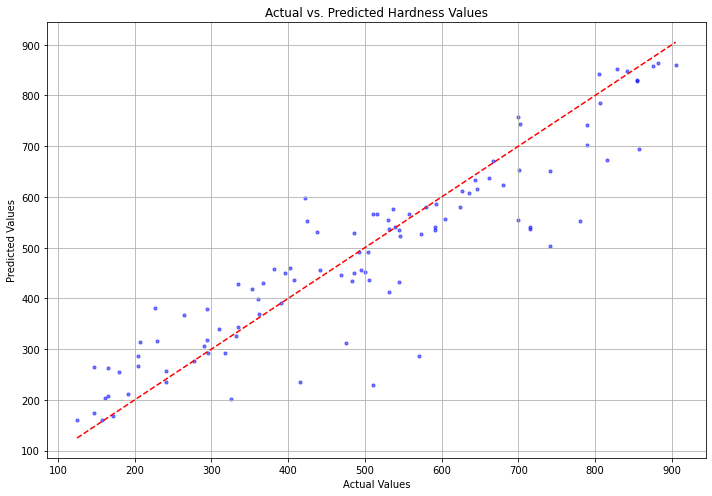

Feature: Mean VEC, Importance: 0.42231861939231363
Feature: Mixing_Enthalpy, Importance: 0.13396021800788066
Feature: Al, Importance: 0.06732276826154016
Feature: Pauling_electronegativity, Importance: 0.04283608533356289
Feature: N, Importance: 0.03759874396726239
Feature: cohesive_enrg, Importance: 0.030466369945124153
Feature: Ionization_enrg, Importance: 0.029265267770152363
Feature: shear_modulus_difference, Importance: 0.023017960467972613
Feature: Work_Function, Importance: 0.021814987130731097
Feature: Atomic_Radius_Difference, Importance: 0.021339084226968414
Feature: Shear_Modulus_G, Importance: 0.01936181591926436
Feature: MOd_Missmatch, Importance: 0.019179618686986553
Feature: melting_Temp, Importance: 0.01428240989547455
Feature: Cr, Importance: 0.01422584719460201
Feature: Cu, Importance: 0.013971333618192222
Feature: Ti, Importance: 0.011037977109882822
Feature: Mn, Importance: 0.010865047838803925
Feature: Co, Importance: 0.010184843891889976
Feature: Mixing_Entropy, I

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('Fernado_1_output.csv')

def get_element_fraction(composition, element):
    if element in composition:
        remainder = composition[composition.index(element) + len(element):]
        import re
        match = re.search(r"(\d+(\.\d+)?)", remainder)
        if match:
            return float(match.group(1))
    return 0.0

METALLIC_ELEMENTS = ["Li", "Be", "B", "C", "N", "O", "Na", "Mg", "Al", "Si", "P", "S",
    "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "Se",
    "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Te",
    "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm",
    "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Tl", "Pb", "Po", "Th", "Pa", "U"]

for element in METALLIC_ELEMENTS:
    df[element] = df['composition'].apply(lambda x: get_element_fraction(x, element))

X = df.drop(columns=['composition', 'hardness'])
y = df['hardness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=65, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
evs = explained_variance_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
print(f"Explained Variance Score: {evs}")

plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, color='blue', s=10, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs. Predicted Hardness Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()

importances = rf.feature_importances_
features = list(X_train.columns)
feature_importances = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")


In [ ]:
############################################# Clasification Random Forest ########################################

Accuracy: 81.01%

Classification Report:
               precision    recall  f1-score   support

         BCC       0.91      0.90      0.91        82
     BCC+Sec       0.71      0.83      0.77        24
         FCC       0.81      0.94      0.87        67
     FCC+BCC       0.62      0.47      0.53        17
 FCC+BCC+Sec       0.64      0.78      0.70         9
     FCC+Sec       0.76      0.57      0.65        23
         HCP       0.71      0.45      0.56        11
         Sec       1.00      0.50      0.67         4

    accuracy                           0.81       237
   macro avg       0.77      0.68      0.71       237
weighted avg       0.81      0.81      0.80       237

Feature: melting_Temp, Importance: 0.08067815574481521
Feature: Ionization_enrg, Importance: 0.07428883618630526
Feature: Mean VEC, Importance: 0.05678168556307958
Feature: Work_Function, Importance: 0.05448437900609102
Feature: cohesive_enrg, Importance: 0.05209739156164149
Feature: Shear_Modulus_G, Impor

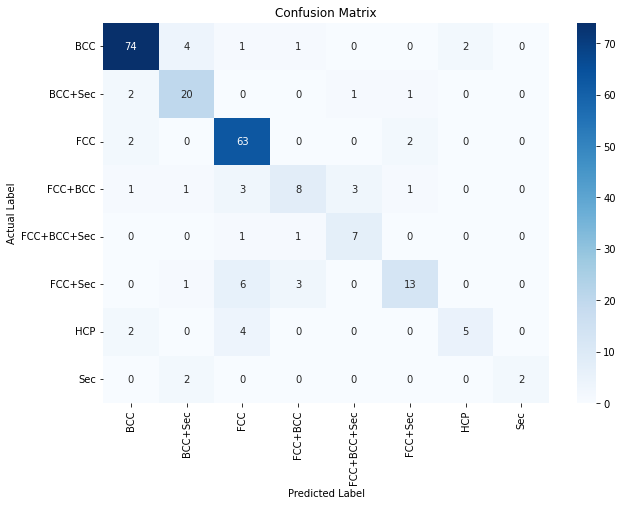

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('Final_Formated_and_cleaned_file_With_Features.csv')
# df = pd.read_csv('Fernado_1_output.csv')

def get_element_fraction(composition, element):
    if element in composition:
        # Extract the portion of the string after the element's name
        remainder = composition[composition.index(element) + len(element):]
        
        # Extract the coefficient using regex
        import re
        match = re.search(r"(\d+(\.\d+)?)", remainder)
        if match:
            return float(match.group(1))
    return 0.0

# Create columns for each metallic element and fill with its coefficient
METALLIC_ELEMENTS = ["Li", "Be", "B", "C", "N", "O", "Na", "Mg", "Al", "Si", "P", "S",
    "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "Se",
    "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Te",
    "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm",
    "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Tl", "Pb", "Po", "Th", "Pa", "U"]

for element in METALLIC_ELEMENTS:
    df[element] = df['composition'].apply(lambda x: get_element_fraction(x, element))


# Drop the original 'composition' column and 'hardness' column
X = df.drop(columns=['composition', 'Phase'])
y = df['Phase']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=60, random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: If you want to see feature importances
importances = clf.feature_importances_
features = list(X_train.columns)
feature_importances = sorted(list(zip(features, importances)), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance}")
    

import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... [rest of your code]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=y.unique(), yticklabels=y.unique())
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 81.43%

Classification Report:
               precision    recall  f1-score   support

         BCC       0.93      0.91      0.92        82
     BCC+Sec       0.77      0.83      0.80        24
         FCC       0.79      0.94      0.86        67
     FCC+BCC       0.62      0.47      0.53        17
 FCC+BCC+Sec       0.64      0.78      0.70         9
     FCC+Sec       0.76      0.57      0.65        23
         HCP       0.71      0.45      0.56        11
         Sec       1.00      0.50      0.67         4

    accuracy                           0.81       237
   macro avg       0.78      0.68      0.71       237
weighted avg       0.81      0.81      0.81       237



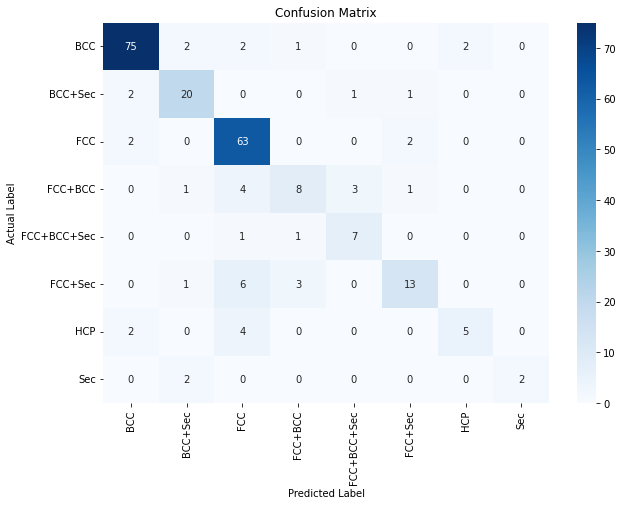

In [9]:
########################################### Batch Predictions Random Forest ########################################

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from joblib import dump, load
import re
import seaborn as sns

def get_element_fraction(composition, element):
    if element in composition:
        remainder = composition[composition.index(element) + len(element):]
        match = re.search(r"(\d+(\.\d+)?)", remainder)
        if match:
            return float(match.group(1))
    return 0.0

def preprocess_new_data(csv_file):
    new_df = pd.read_csv(csv_file)
    compositions = new_df['composition'].copy()
    for element in METALLIC_ELEMENTS:
        new_df[element] = new_df['composition'].apply(lambda x: get_element_fraction(x, element))
    new_X = new_df.drop(columns=['composition'])
    return new_X, compositions

# Load the data
df = pd.read_csv('Final_Formated_and_cleaned_file_With_Features.csv')

METALLIC_ELEMENTS = ["Li", "Be", "B", "C", "N", "O", "Na", "Mg", "Al", "Si", "P", "S",
    "K", "Ca", "Sc", "Ti", "V", "Cr", "Mn", "Fe", "Co", "Ni", "Cu", "Zn", "Ga", "Ge", "Se",
    "Rb", "Sr", "Y", "Zr", "Nb", "Mo", "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", "Te",
    "Cs", "Ba", "La", "Ce", "Pr", "Nd", "Pm", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm",
    "Yb", "Lu", "Hf", "Ta", "W", "Re", "Os", "Ir", "Pt", "Au", "Tl", "Pb", "Po", "Th", "Pa", "U"]

for element in METALLIC_ELEMENTS:
    df[element] = df['composition'].apply(lambda x: get_element_fraction(x, element))

X = df.drop(columns=['composition', 'Phase'])
y = df['Phase']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Save the trained model
dump(clf, 'random_forest_model.joblib')

# Evaluate model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=y.unique(), yticklabels=y.unique())
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Batch predictions on new data
# Load the saved model
clf_loaded = load('random_forest_model.joblib')

# Assuming the new data is in 'new_compositions_features.csv'
new_data, new_compositions = preprocess_new_data('new_compositions_features.csv')

# Make predictions on new data
new_predictions = clf_loaded.predict(new_data)

# Combine compositions and predictions into a new DataFrame
final_predictions_df = pd.DataFrame({
    'composition': new_compositions,
    'Predicted_Phase': new_predictions
})

# Save this new DataFrame to a new CSV file
final_predictions_df.to_csv('new_compositions_features_with_predictions.csv', index=False)
